# Sensitivity Analysis overview

1. Run 10,000 replications for each group with and without intervention, with sensitivity variable scaling
    - For each replication, for each variable, sample from (0.8, 1.2) and scale the variable by the sampled value
    - Store the sampled scalars for each variable
2. Load diabetes data for no intervention (baseline) and with intervention (variable)
    - Reduce to 2500 replications because of computational burden
3. Filter data
    - Only keep data for agents who have initiated ART between 2013 and 2017
    - Only keep data for agents who have received an intervention
4. Calculate risk and number of dm diagnosis by group for both baseline and variable
    - Store median risk and dm diagnosis by group across all replications for both baseline and variable
5. Calculate median difference measures
    - absolute risk difference = (variable risk) - (baseline risk)
    - relative risk difference = (absolute risk difference) / (baseline risk)
    - absolute dm difference = variable dm cases - baseline dm cases
    - store median absolute risk difference, relative risk difference, and absolute dm difference
6. Calculate tornado plot values
    - For each sensitivity analysis variable, subset for the upper and lower 20% within each population group for both baseline and variable
    - Sample 1000 replications from each of the upper and bottom 20% within each population for both baseline and variable
    - Calculate the pairwise difference between variable and baseline for both upper and lower 20% for both relative and absolute difference.
    - Store the 20th, median, and 80th quartile for pairwise difference
7. Plot difference with quantile bounds
    - Flip x-axis to show reduction instead of difference

In [1]:
from pathlib import Path

from dask import dataframe as dd
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pearl.post_processing.bmi import (
    add_overall,
    calc_risk_by_group,
    clean_control,
    group_title_dict,
)


In [2]:
use_baseline = False
num_replications = 2500
num_samples = 10000

In [3]:
if use_baseline:
    baseline = Path("/workspaces/pearlModel/out/S0_1000/combined")
    variable = Path("/workspaces/pearlModel/out/S3_1000/combined")
baseline_sa = Path("/workspaces/pearlModel/out/S0_SA_10000/combined")
variable_sa = Path("/workspaces/pearlModel/out/S3_SA_10000/combined")

In [4]:
target_columns = ['dm_prevalence_prev',
                  'dm_prevalence',
                  'dm_incidence',
                  'pre_art_bmi',
                  'post_art_bmi',
                  'art_initiators']

In [5]:
if use_baseline:
    param_df_baseline = pd.read_parquet(baseline / "parameters.parquet").reset_index(drop=True)
    param_df_variable = pd.read_parquet(variable / "parameters.parquet").reset_index(drop=True)
param_df_baseline_sa = pd.read_parquet(baseline_sa / "parameters.parquet").reset_index(drop=True)
param_df_variable_sa = pd.read_parquet(variable_sa / "parameters.parquet").reset_index(drop=True)

In [6]:
def add_overall_to_params(params):
    group = params['group'].unique()[1]
    overall = params[params['group']==group]
    overall['group'] = 'overall'
    params = pd.concat([params, overall])
    return params.reset_index(drop=True)

In [7]:
# add overall to params
if use_baseline:
    param_df_baseline = add_overall_to_params(param_df_baseline)
    param_df_variable = add_overall_to_params(param_df_variable)
param_df_baseline_sa = add_overall_to_params(param_df_baseline_sa)
param_df_variable_sa = add_overall_to_params(param_df_variable_sa)

/tmp/ipykernel_446676/2444569115.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overall['group'] = 'overall'
/tmp/ipykernel_446676/2444569115.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overall['group'] = 'overall'


### First lets look at the differences between the sensitivity analysis run and the unaltered runs in the S0 scenario

In [8]:
# load the baseline data
if use_baseline:
    bmi_int_dm_prev_baseline = dd.read_parquet(baseline / "dm_final_output.parquet")
bmi_int_dm_prev_baseline_sa = dd.read_parquet(baseline_sa / "dm_final_output.parquet")

In [9]:
# reduce to a manageable size
bmi_int_dm_prev_baseline_sa = bmi_int_dm_prev_baseline_sa[bmi_int_dm_prev_baseline_sa['replication'] < num_replications]

In [10]:
# add overall
if use_baseline:
    bmi_int_dm_prev_baseline = add_overall(bmi_int_dm_prev_baseline)
bmi_int_dm_prev_baseline_sa = add_overall(bmi_int_dm_prev_baseline_sa)

In [11]:
# clean to control specifications
if use_baseline:
    control_bmi_int_dm_prev_baseline = clean_control(bmi_int_dm_prev_baseline, only_eligible=True, only_received=True)
control_bmi_int_dm_prev_baseline_sa = clean_control(bmi_int_dm_prev_baseline_sa, only_eligible=True, only_received=True)

# filter for only people eligible for intervention
if use_baseline:
    bmi_int_eligible_risk_baseline = calc_risk_by_group(control_bmi_int_dm_prev_baseline, 7).compute()
bmi_int_eligible_risk_baseline_sa = calc_risk_by_group(control_bmi_int_dm_prev_baseline_sa, 7).compute()

In [12]:
if use_baseline:
    baseline_risk_median = bmi_int_eligible_risk_baseline.groupby('group')['risk'].median().reset_index()
    baseline_risk_median

In [13]:
baseline_risk_sa_median = bmi_int_eligible_risk_baseline_sa.groupby('group')['risk'].median().reset_index()
baseline_risk_sa_median

,group,risk
0,het_black_female,23.954894
1,het_black_male,19.904183
2,het_hisp_female,21.493737
3,het_hisp_male,18.961103
4,het_white_female,22.183484
5,het_white_male,18.029187
6,idu_black_female,27.037441
7,idu_black_male,14.899201
8,idu_hisp_female,28.686173
9,idu_hisp_male,9.670293


In [14]:
baseline_dm_sa_median = bmi_int_eligible_risk_baseline_sa.groupby('group')['dm_num'].median().reset_index()
baseline_dm_sa_median

,group,dm_num
0,het_black_female,1547.5
1,het_black_male,823.5
2,het_hisp_female,400.0
3,het_hisp_male,254.0
4,het_white_female,361.5
5,het_white_male,168.0
6,idu_black_female,202.0
7,idu_black_male,250.5
8,idu_hisp_female,107.0
9,idu_hisp_male,145.0


In [15]:
if use_baseline:
    ((baseline_risk_sa_median['risk'] - baseline_risk_median['risk']) / baseline_risk_median['risk']) * 100

In [16]:
bmi_int_eligible_risk_baseline_sa.to_parquet(baseline_sa / "baseline_risk_sa.parquet")

### Let's do the same for the intervention run

In [9]:
# load the variable data
if use_baseline:
    bmi_int_dm_prev_variable = dd.read_parquet(variable / "dm_final_output.parquet")
bmi_int_dm_prev_variable_sa = dd.read_parquet(variable_sa / "dm_final_output.parquet")

# reduce to a manageable size
bmi_int_dm_prev_variable_sa = bmi_int_dm_prev_variable_sa[bmi_int_dm_prev_variable_sa['replication'] < num_replications]

# add overall
if use_baseline:
    bmi_int_dm_prev_variable = add_overall(bmi_int_dm_prev_variable)
bmi_int_dm_prev_variable_sa = add_overall(bmi_int_dm_prev_variable_sa)

In [10]:
# clean to control specifications
if use_baseline:
    control_bmi_int_dm_prev_variable = clean_control(bmi_int_dm_prev_variable, only_eligible=True, only_received=True)
control_bmi_int_dm_prev_variable_sa = clean_control(bmi_int_dm_prev_variable_sa, only_eligible=True, only_received=True)

# filter for only people eligible for intervention
if use_baseline:
    bmi_int_eligible_risk_variable = calc_risk_by_group(control_bmi_int_dm_prev_variable, 7).compute()
bmi_int_eligible_risk_variable_sa = calc_risk_by_group(control_bmi_int_dm_prev_variable_sa, 7).compute()

In [11]:
if use_baseline:
    variable_risk_median = bmi_int_eligible_risk_variable.groupby('group')['risk'].median().reset_index()
    variable_risk_median

In [ ]:
variable_risk_sa_median = bmi_int_eligible_risk_variable_sa.groupby('group')['risk'].median().reset_index()
variable_risk_sa_median

,group,risk
0,het_black_female,18.986683
1,het_black_male,14.894777
2,het_hisp_female,17.739218
3,het_hisp_male,13.165732
4,het_white_female,18.229333
5,het_white_male,13.289037
6,idu_black_female,22.489378
7,idu_black_male,10.762693
8,idu_hisp_female,22.428995
9,idu_hisp_male,8.818909


In [13]:
variable_dm_sa_median = bmi_int_eligible_risk_variable_sa.groupby('group')['dm_num'].median().reset_index()
variable_dm_sa_median

,group,dm_num
0,het_black_female,1238.0
1,het_black_male,600.0
2,het_hisp_female,332.0
3,het_hisp_male,171.0
4,het_white_female,297.0
5,het_white_male,120.0
6,idu_black_female,167.0
7,idu_black_male,180.0
8,idu_hisp_female,84.0
9,idu_hisp_male,131.0


In [14]:
if use_baseline:    
    ((variable_risk_sa_median['risk'] - variable_risk_median['risk']) / variable_risk_median['risk']) * 100

In [15]:
bmi_int_eligible_risk_variable_sa.to_parquet(variable_sa / "variable_risk_sa.parquet")

# Load back data

In [9]:
#load back the base data
bmi_int_eligible_risk_baseline_sa = pd.read_parquet(baseline_sa / "baseline_risk_sa.parquet")
bmi_int_eligible_risk_variable_sa = pd.read_parquet(variable_sa / "variable_risk_sa.parquet")
baseline_risk_sa_median = bmi_int_eligible_risk_baseline_sa.groupby('group')['risk'].median().reset_index()
variable_risk_sa_median = bmi_int_eligible_risk_variable_sa.groupby('group')['risk'].median().reset_index()

In [10]:
baseline_dm_sa_median = bmi_int_eligible_risk_baseline_sa.groupby('group')['dm_num'].median().reset_index()
variable_dm_sa_median = bmi_int_eligible_risk_variable_sa.groupby('group')['dm_num'].median().reset_index()

### Now let us look at the risk differences for non SA

In [11]:
if use_baseline:
    # gather samples from each non SA run
    baseline_risk = bmi_int_eligible_risk_baseline.groupby('group').sample(num_samples, replace=True).reset_index()
    variable_risk = bmi_int_eligible_risk_variable.groupby('group').sample(num_samples, replace=True).reset_index()

In [12]:
if use_baseline:
    # absolute difference
    risk_df = pd.DataFrame(variable_risk['risk'] - baseline_risk['risk'])

    # relative difference
    risk_df_relative = pd.DataFrame((variable_risk['risk'] - baseline_risk['risk'])/baseline_risk['risk'])

    # add back the group column that is lost
    risk_df['group'] = baseline_risk['group']
    risk_df_relative['group'] = baseline_risk['group']

In [13]:
if use_baseline:   
    # take the median across groups
    baseline_risk_difference_df = risk_df.groupby('group').median().reset_index()
    baseline_risk_difference_df_relative = risk_df_relative.groupby('group').median().reset_index()

In [14]:
if use_baseline:
    baseline_risk_difference_df

### And the same for SA

In [15]:
# gather samples from each SA run
baseline_risk_sa = bmi_int_eligible_risk_baseline_sa.groupby('group').sample(num_samples, replace=True).reset_index()
variable_risk_sa = bmi_int_eligible_risk_variable_sa.groupby('group').sample(num_samples, replace=True).reset_index()

In [16]:
# absolute difference
risk_df_sa = pd.DataFrame(variable_risk_sa['risk'] - baseline_risk_sa['risk'])

# relative difference
risk_df_sa_relative = pd.DataFrame((variable_risk_sa['risk'] - baseline_risk_sa['risk'])/baseline_risk_sa['risk'])

# add back the group column that is lost
risk_df_sa['group'] = baseline_risk_sa['group']
risk_df_sa_relative['group'] = baseline_risk_sa['group']

In [17]:
# absolute difference
dm_df_sa = pd.DataFrame(variable_risk_sa['dm_num'] - baseline_risk_sa['dm_num'])

# relative difference
dm_df_sa_relative = pd.DataFrame((variable_risk_sa['dm_num'] - baseline_risk_sa['dm_num'])/baseline_risk_sa['dm_num'])

# add back the group column that is lost
dm_df_sa['group'] = baseline_risk_sa['group']
dm_df_sa_relative['group'] = baseline_risk_sa['group']

In [18]:
# take the median across groups
baseline_risk_difference_df_sa = risk_df_sa.groupby('group').median().reset_index()
baseline_risk_difference_df_sa_relative = risk_df_sa_relative.groupby('group').median().reset_index()

In [19]:
# take the median across groups
baseline_dm_difference_df_sa = dm_df_sa.groupby('group').median().reset_index()
baseline_dm_difference_df_sa_relative = dm_df_sa_relative.groupby('group').median().reset_index()

In [20]:
baseline_risk_difference_df_sa

,group,risk
0,het_black_female,-5.091786
1,het_black_male,-5.153842
2,het_hisp_female,-3.992807
3,het_hisp_male,-6.152557
4,het_white_female,-3.936977
5,het_white_male,-4.983760
6,idu_black_female,-4.664120
7,idu_black_male,-3.994225
8,idu_hisp_female,-6.219959
9,idu_hisp_male,-0.899648


In [21]:
baseline_dm_difference_df_sa

,group,dm_num
0,het_black_female,-333.0
1,het_black_male,-223.0
2,het_hisp_female,-73.0
3,het_hisp_male,-85.0
4,het_white_female,-65.0
5,het_white_male,-49.0
6,idu_black_female,-35.0
7,idu_black_male,-71.0
8,idu_hisp_female,-23.0
9,idu_hisp_male,-14.0


### SA Tornado plots

In [22]:
def calc_tornado_vals(baseline_risk_df,
                      variable_risk_df,
                      param_df_baseline,
                      param_df_variable,
                      col_name,
                      target_col="risk",
                      num_samples=1000,
                      lesser=0.1,
                      greater=0.9):
    
    sub_param_baseline = param_df_baseline[['replication', 'group', col_name]]
    sub_param_variable = param_df_variable[['replication', 'group', col_name]]
    
    baseline_merged = sub_param_baseline.merge(baseline_risk_df, on=['replication', 'group'], how='right').fillna(0)
    variable_merged = sub_param_variable.merge(variable_risk_df, on=['replication', 'group'], how='right').fillna(0)
    
    quantile_val_baseline = baseline_merged.groupby('group')[col_name].quantile([lesser, greater]).unstack().reset_index()
    quantile_val_variable = variable_merged.groupby('group')[col_name].quantile([lesser, greater]).unstack().reset_index()
    
    difference_tornado_df = []
    relative_tornado_df = []
    baseline_tornado_df = []
    variable_tornado_df = []
    for group in quantile_val_baseline['group'].unique():
        group_df_baseline = baseline_merged[baseline_merged['group'] == group]
        group_df_variable = variable_merged[variable_merged['group'] == group]

        lesser_val_baseline = quantile_val_baseline[quantile_val_baseline['group'] == group][lesser].values[0]
        greater_val_baseline = quantile_val_baseline[quantile_val_baseline['group'] == group][greater].values[0]
        lesser_val_variable = quantile_val_variable[quantile_val_variable['group'] == group][lesser].values[0]
        greater_val_variable = quantile_val_variable[quantile_val_variable['group'] == group][greater].values[0]
        
        lesser_group_df_baseline = group_df_baseline[group_df_baseline[col_name] <= lesser_val_baseline]
        greater_group_df_baseline = group_df_baseline[group_df_baseline[col_name] >= greater_val_baseline]
        lesser_group_df_variable = group_df_variable[group_df_variable[col_name] <= lesser_val_variable]
        greater_group_df_variable = group_df_variable[group_df_variable[col_name] >= greater_val_variable]
        
        lesser_group_df_baseline_sample = lesser_group_df_baseline.sample(num_samples, replace=True).reset_index()
        greater_group_df_baseline_sample = greater_group_df_baseline.sample(num_samples, replace=True).reset_index()
        lesser_group_df_variable_sample = lesser_group_df_variable.sample(num_samples, replace=True).reset_index()
        greater_group_df_variable_sample = greater_group_df_variable.sample(num_samples, replace=True).reset_index()
        
        baseline_group_tornado_df = {
            'group': group,
            'variable': col_name,
            lesser: (lesser_group_df_baseline_sample[target_col]).quantile([lesser,0.5,greater]),
            greater: (greater_group_df_baseline_sample[target_col]).quantile([lesser,0.5,greater]),
            'lesser_count': lesser_group_df_baseline[target_col].count(),
            'greater_count': greater_group_df_baseline[target_col].count(),
        }
        baseline_tornado_df.append(baseline_group_tornado_df)
        variable_group_tornado_df = {
            'group': group,
            'variable': col_name,
            lesser: (lesser_group_df_variable_sample[target_col]).quantile([lesser,0.5,greater]),
            greater: (greater_group_df_variable_sample[target_col]).quantile([lesser,0.5,greater]),
            'lesser_count': lesser_group_df_variable[target_col].count(),
            'greater_count': greater_group_df_variable[target_col].count(),
        }
        variable_tornado_df.append(variable_group_tornado_df)
        difference_group_tornado_df = {
            'group': group,
            'variable': col_name,
            lesser: (lesser_group_df_variable_sample[target_col] - lesser_group_df_baseline_sample[target_col]).quantile([lesser,0.5,greater]),
            greater: (greater_group_df_variable_sample[target_col] - greater_group_df_baseline_sample[target_col]).quantile([lesser,0.5,greater])
        }
        difference_tornado_df.append(difference_group_tornado_df)
        
        relative_group_tornado_df = {
            'group': group,
            'variable': col_name,
            lesser: ((lesser_group_df_variable_sample[target_col] - lesser_group_df_baseline_sample[target_col])/lesser_group_df_baseline_sample[target_col]).quantile([lesser,0.5,greater]),
            greater: ((greater_group_df_variable_sample[target_col] - greater_group_df_baseline_sample[target_col])/lesser_group_df_baseline_sample[target_col]).quantile([lesser,0.5,greater])
        }
        relative_tornado_df.append(relative_group_tornado_df)
    
    baseline_tornado_df = pd.DataFrame(baseline_tornado_df)
    variable_tornado_df = pd.DataFrame(variable_tornado_df)
    difference_tornado_df = pd.DataFrame(difference_tornado_df)
    relative_tornado_df = pd.DataFrame(relative_tornado_df)
    return baseline_tornado_df, variable_tornado_df, difference_tornado_df, relative_tornado_df

In [23]:
variable_name_map = {
    'dm_prevalence_prev' : 'Prevalence of diabetes among ART users in 2009',
    'dm_prevalence' : 'Prevalence of diabetes among ART initiators',
    'dm_incidence' : 'Incidence of diabetes among ART users',
    'pre_art_bmi' : 'BMI at ART initiation',
    'post_art_bmi' : 'BMI at two years post-ART initiation',
    'art_initiators' : 'Number of ART initiator population (2010-2030)'
}

In [24]:
baseline_tornado_vals = []
variable_tornado_vals = []
difference_tornado_vals = []
relative_tornado_vals = []
for col in target_columns:
    baseline_vals, variable_vals, difference_vals, relative_difference_vals = calc_tornado_vals(
                                                                    bmi_int_eligible_risk_baseline_sa,
                                                                    bmi_int_eligible_risk_variable_sa,
                                                                    param_df_baseline_sa,
                                                                    param_df_variable_sa,
                                                                    col,
                                                                    target_col="risk",
                                                                    num_samples=num_samples,
                                                                    lesser=0.20,
                                                                    greater=0.80)
    
    baseline_tornado_vals.append(baseline_vals)
    variable_tornado_vals.append(variable_vals)
    difference_tornado_vals.append(difference_vals)
    relative_tornado_vals.append(relative_difference_vals)
    
baseline_tornado_vals = pd.concat(baseline_tornado_vals).reset_index(drop=True)    
variable_tornado_vals = pd.concat(variable_tornado_vals).reset_index(drop=True)
difference_tornado_vals = pd.concat(difference_tornado_vals).reset_index(drop=True)
relative_tornado_vals = pd.concat(relative_tornado_vals).reset_index(drop=True)

# rename variable to semantic labels
baseline_tornado_vals['variable'] = baseline_tornado_vals['variable'].map(variable_name_map)
variable_tornado_vals['variable'] = variable_tornado_vals['variable'].map(variable_name_map)
difference_tornado_vals['variable'] = difference_tornado_vals['variable'].map(variable_name_map)
relative_tornado_vals['variable'] = relative_tornado_vals['variable'].map(variable_name_map)

In [25]:
def multi_tornado_plot(tornado_vals, baseline_vals, x_axis_title, flip=True, target_column="risk"):
    # create an axis
    fig, axs = plt.subplots(5, 3, figsize=(20, 20))
    
    # get the groups for plotting and sort them
    plot_groups = np.sort(tornado_vals.group.unique())
    
    # remove overall
    plot_groups = [item for item in plot_groups if item != "overall"]
    
    plot_groups_reordered = ['het_black_female', 'het_white_female', 'het_hisp_female',
                         'het_black_male', 'het_white_male', 'het_hisp_male',
                         'idu_black_female', 'idu_white_female', 'idu_hisp_female',
                         'idu_black_male', 'idu_white_male', 'idu_hisp_male',
                         'msm_black_male', 'msm_white_male', 'msm_hisp_male']
    
    column_names = ['Black', 'White', 'Hispanic']

    row_names = ['HET Women', 'HET Men', 'WWID', 'MWID', 'MSM']
    
    for i, group in enumerate(plot_groups_reordered):
    
        group_vals = tornado_vals[tornado_vals['group']==group].reset_index(drop=True)
        ax = axs.flatten()[i]
        
        if i < 3:
            ax.set_title(column_names[i], fontweight='bold', fontsize=24)

        if i % 3 == 0:
            k = i // 3
            ax.set_ylabel(row_names[k], fontweight='bold', fontsize=24)
        
        # plot parameters
        y_tick_label = group_vals['variable']
        ys = range(len(y_tick_label))[::-1]
        
        color_lesser = 'red'
        color_greater = 'blue'
        color_line = 'black'

        # Data to be visualized
        lesser_value = group_vals.iloc[:,2].values
        greater_value = group_vals.iloc[:,3].values
        base = baseline_vals[baseline_vals['group']==group][target_column].values[0]
        
        if flip:
            base *= -1
        
        # Add vertical line for median value
        ax.axvline(base, color=color_line, linewidth=2, label='Median value', linestyle='--')

        # Draw bars
        for y, value, value2 in zip(ys, lesser_value, greater_value):
            
            if flip:
                value = value.copy() * -1
                value2 = value2.copy() * -1
            
            # draw horizontal line markers for the uncertainty around lesser and greater
            ax.plot((value.iloc[0], value.iloc[2]), (y, y), linewidth=2, color=color_lesser, marker='|', markersize=15)
            ax.plot((value2.iloc[0], value2.iloc[2]), (y, y), linewidth=2, color=color_greater, marker='|', markersize=15)
            
            # draw markers for the median values
            ax.plot(value2.iloc[1], y , 'o', color=color_greater, markersize=15)
            ax.plot(value.iloc[1], y , 'o', color=color_lesser, markersize=15)
            
            


        
        if i % 3 == 0:
            # Modify the graph
            ax.set_ylim([-1.5, 6])
            ax.set_yticks(ys)
            ax.set_yticklabels(y_tick_label)
        else:
           ax.tick_params(labelleft=False, left=False) 
        ax.tick_params(axis='both', which='major', labelsize=12)
        
    # Add legend
    handles = [Patch(color=color_lesser, label='Bottom 20th Percentile'), Patch(color=color_greater, label='Top 20th Percentile'),
        Line2D([0], [0], color=color_line, linewidth=1.5, label='Median value')]
    fig.legend(handles=handles, loc='lower left', prop={'size': 20})
        
    fig.supxlabel(x_axis_title, fontsize=24)
        
    return fig
        

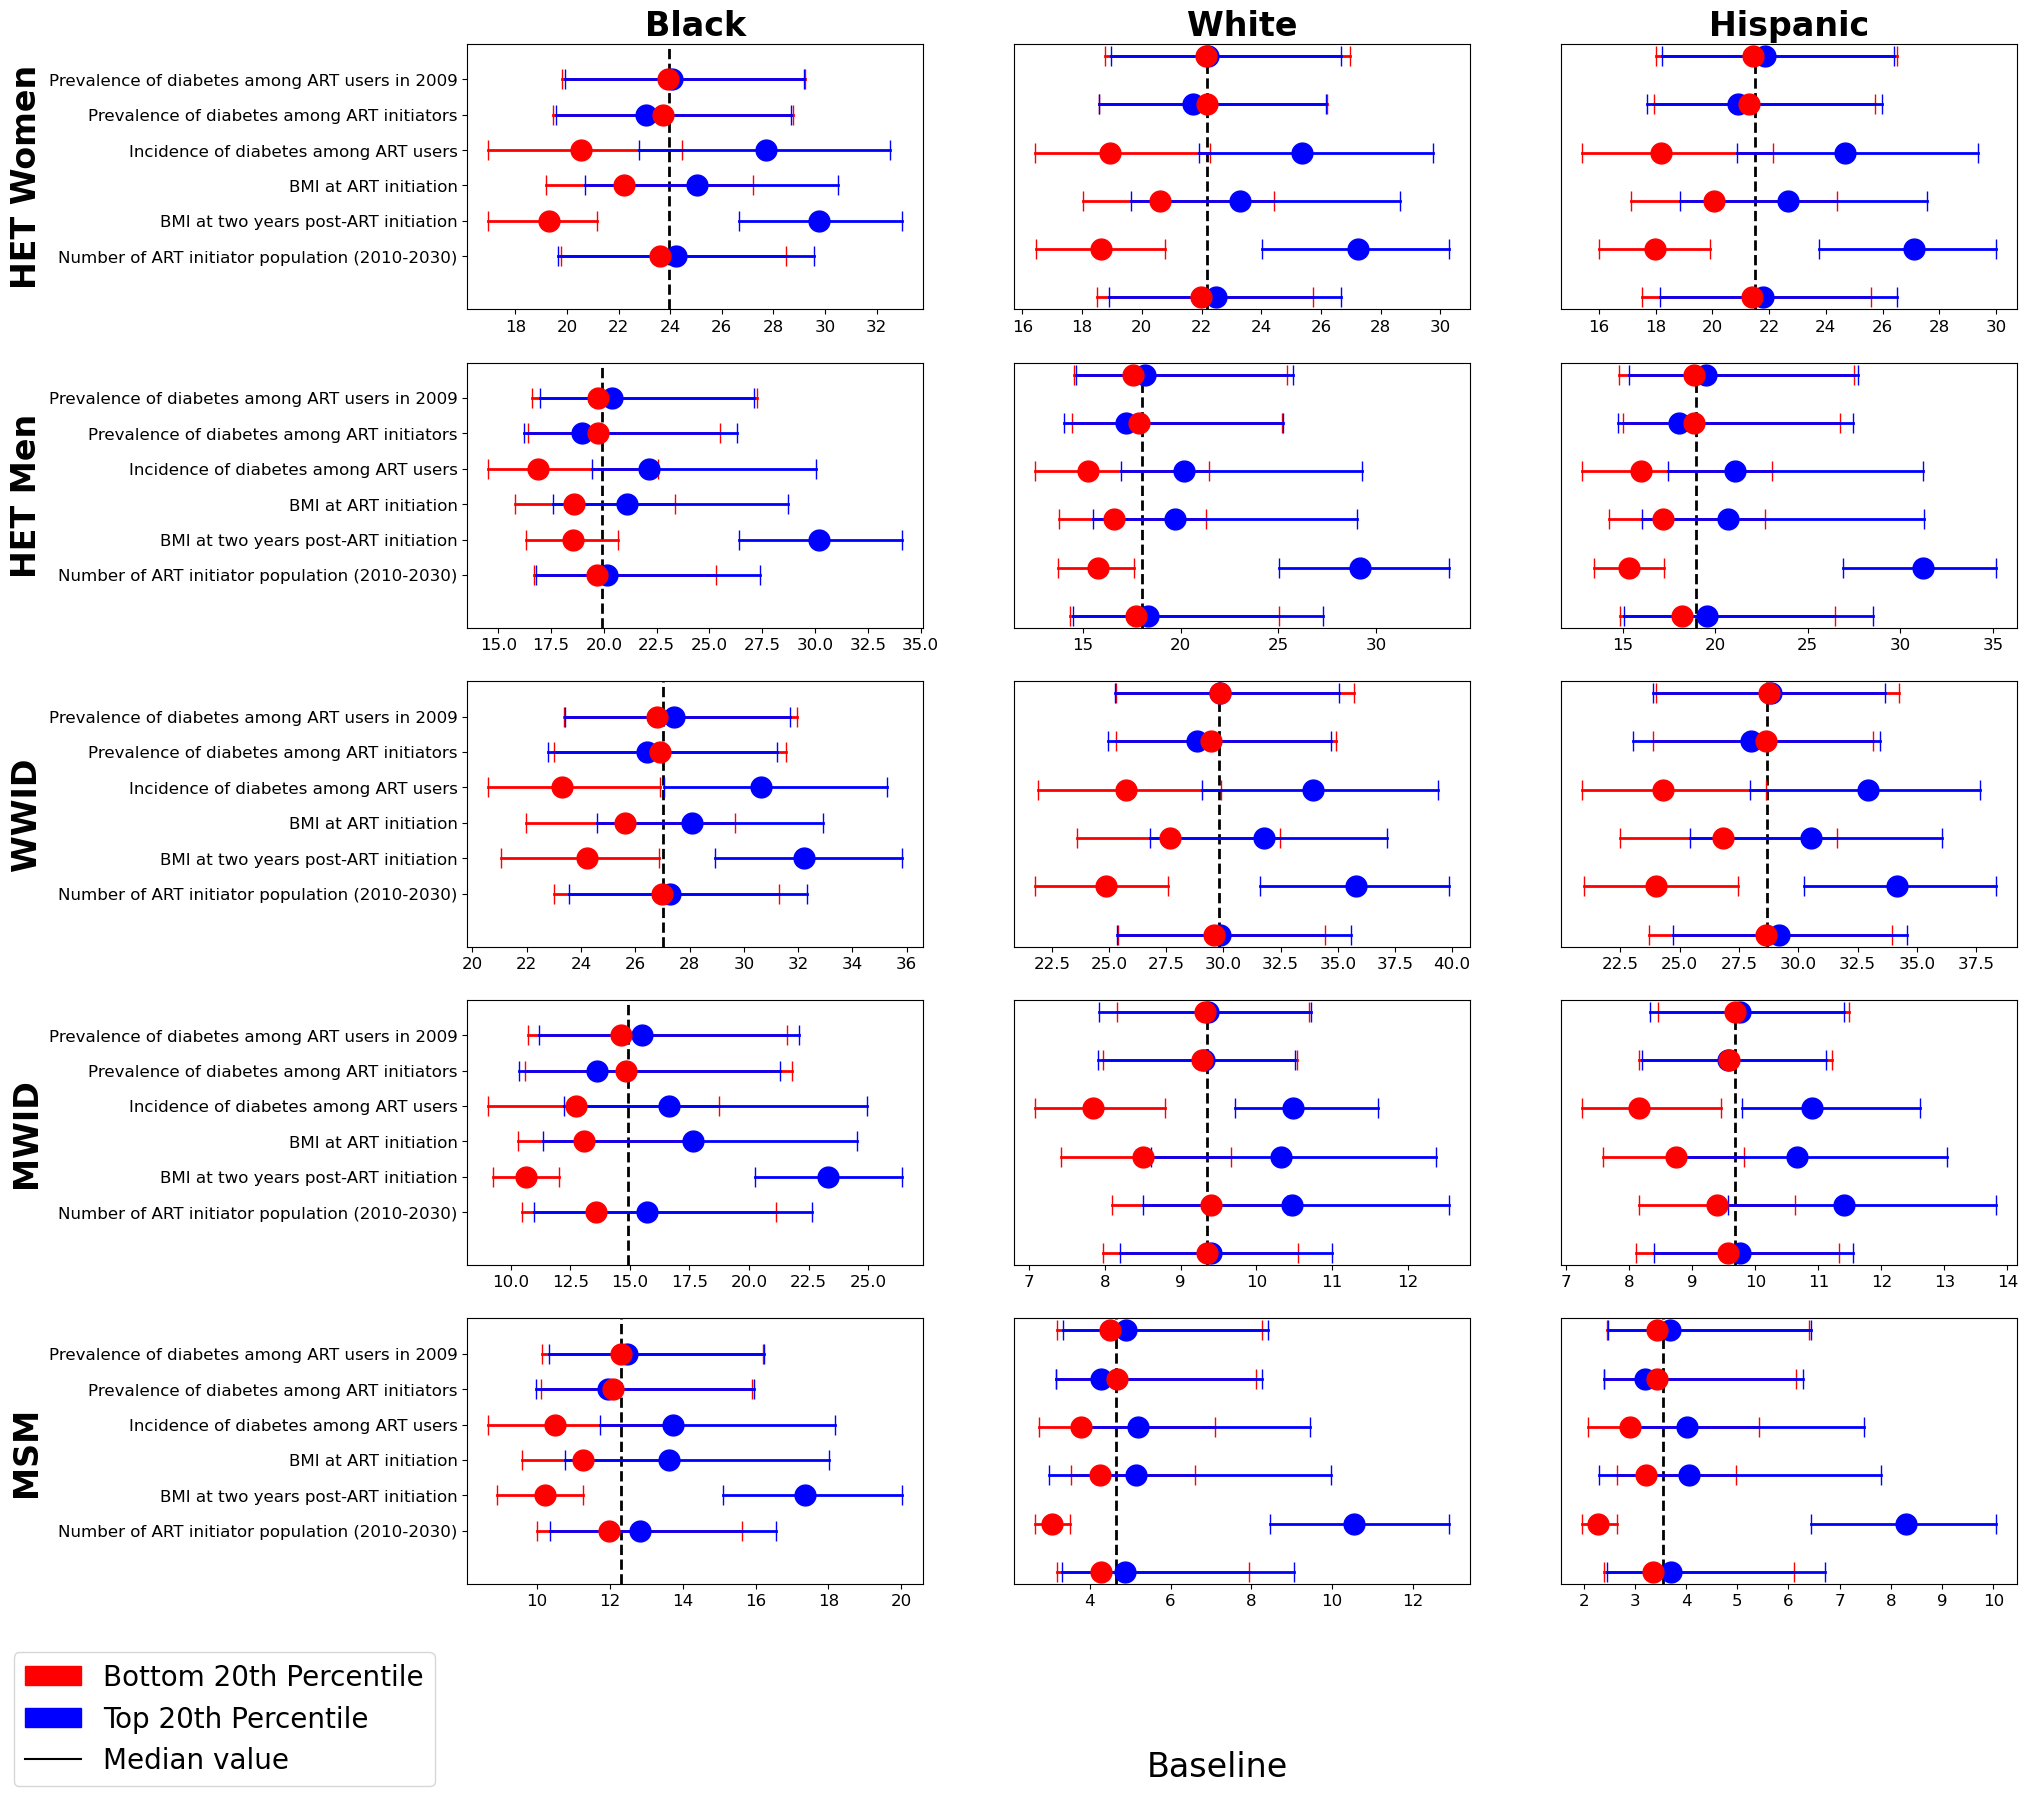

In [26]:
fig = multi_tornado_plot(baseline_tornado_vals, baseline_risk_sa_median, "Baseline", flip=False)

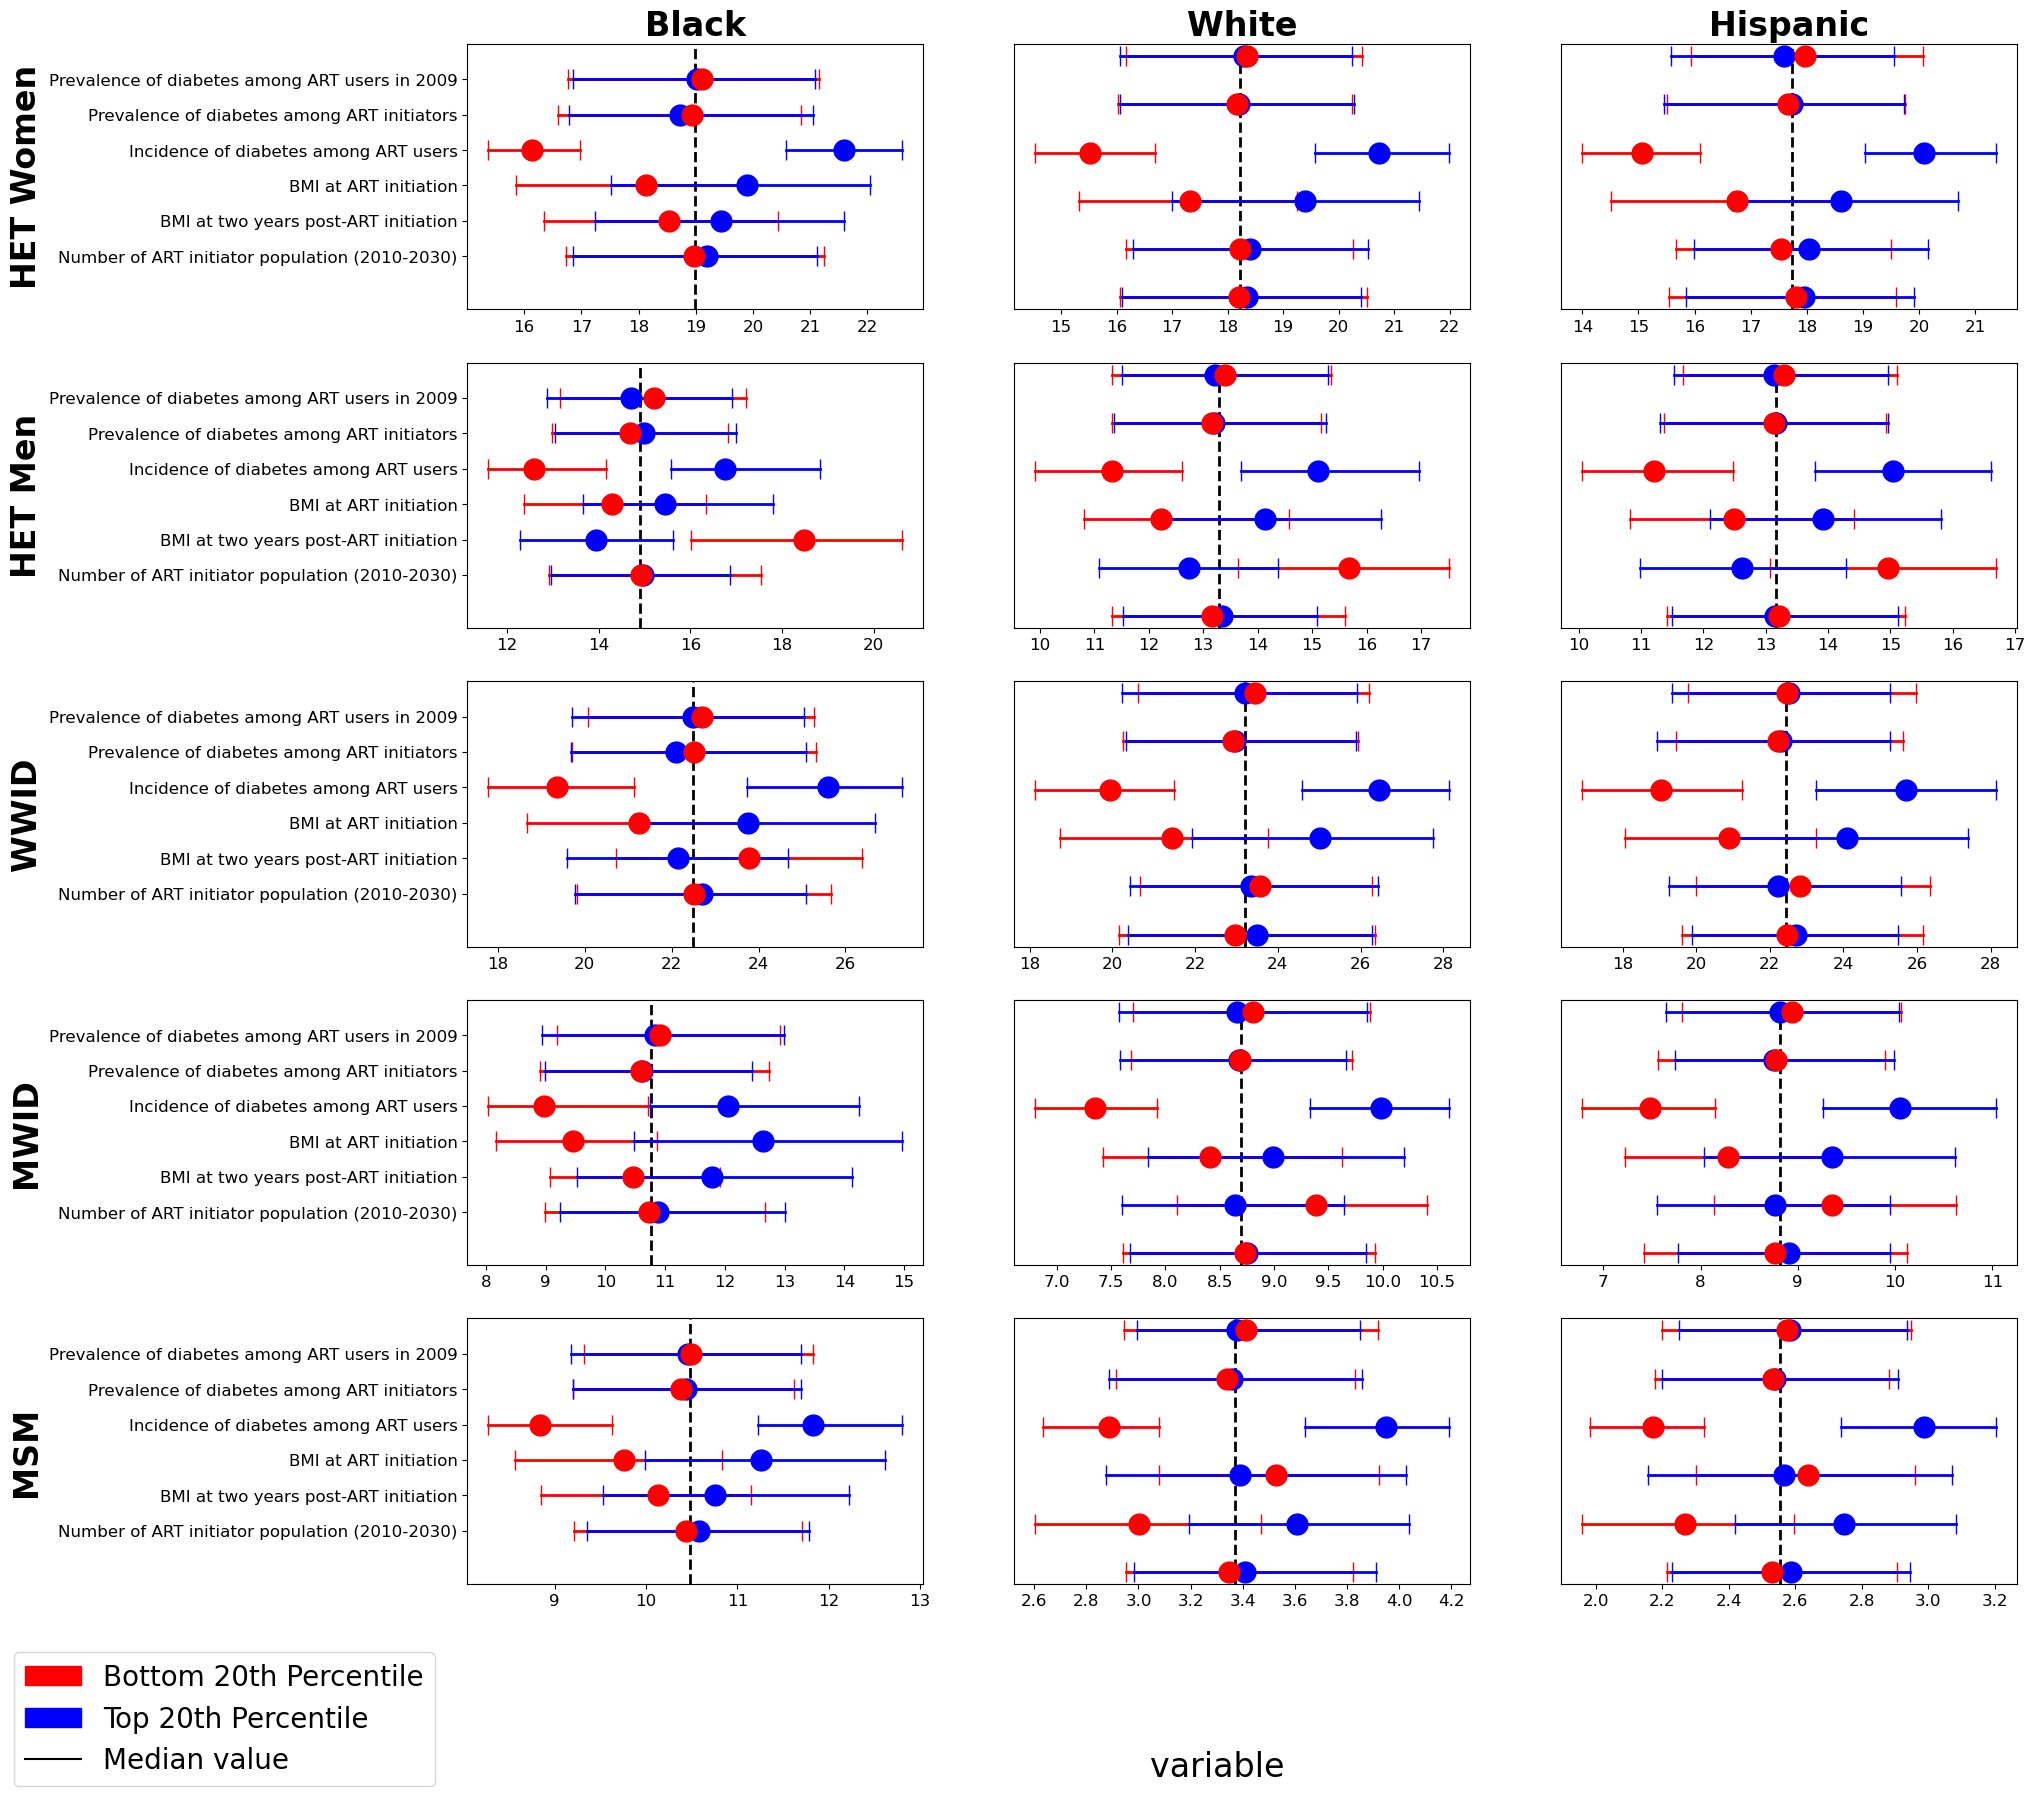

In [27]:
fig = multi_tornado_plot(variable_tornado_vals, variable_risk_sa_median, "variable", flip=False)

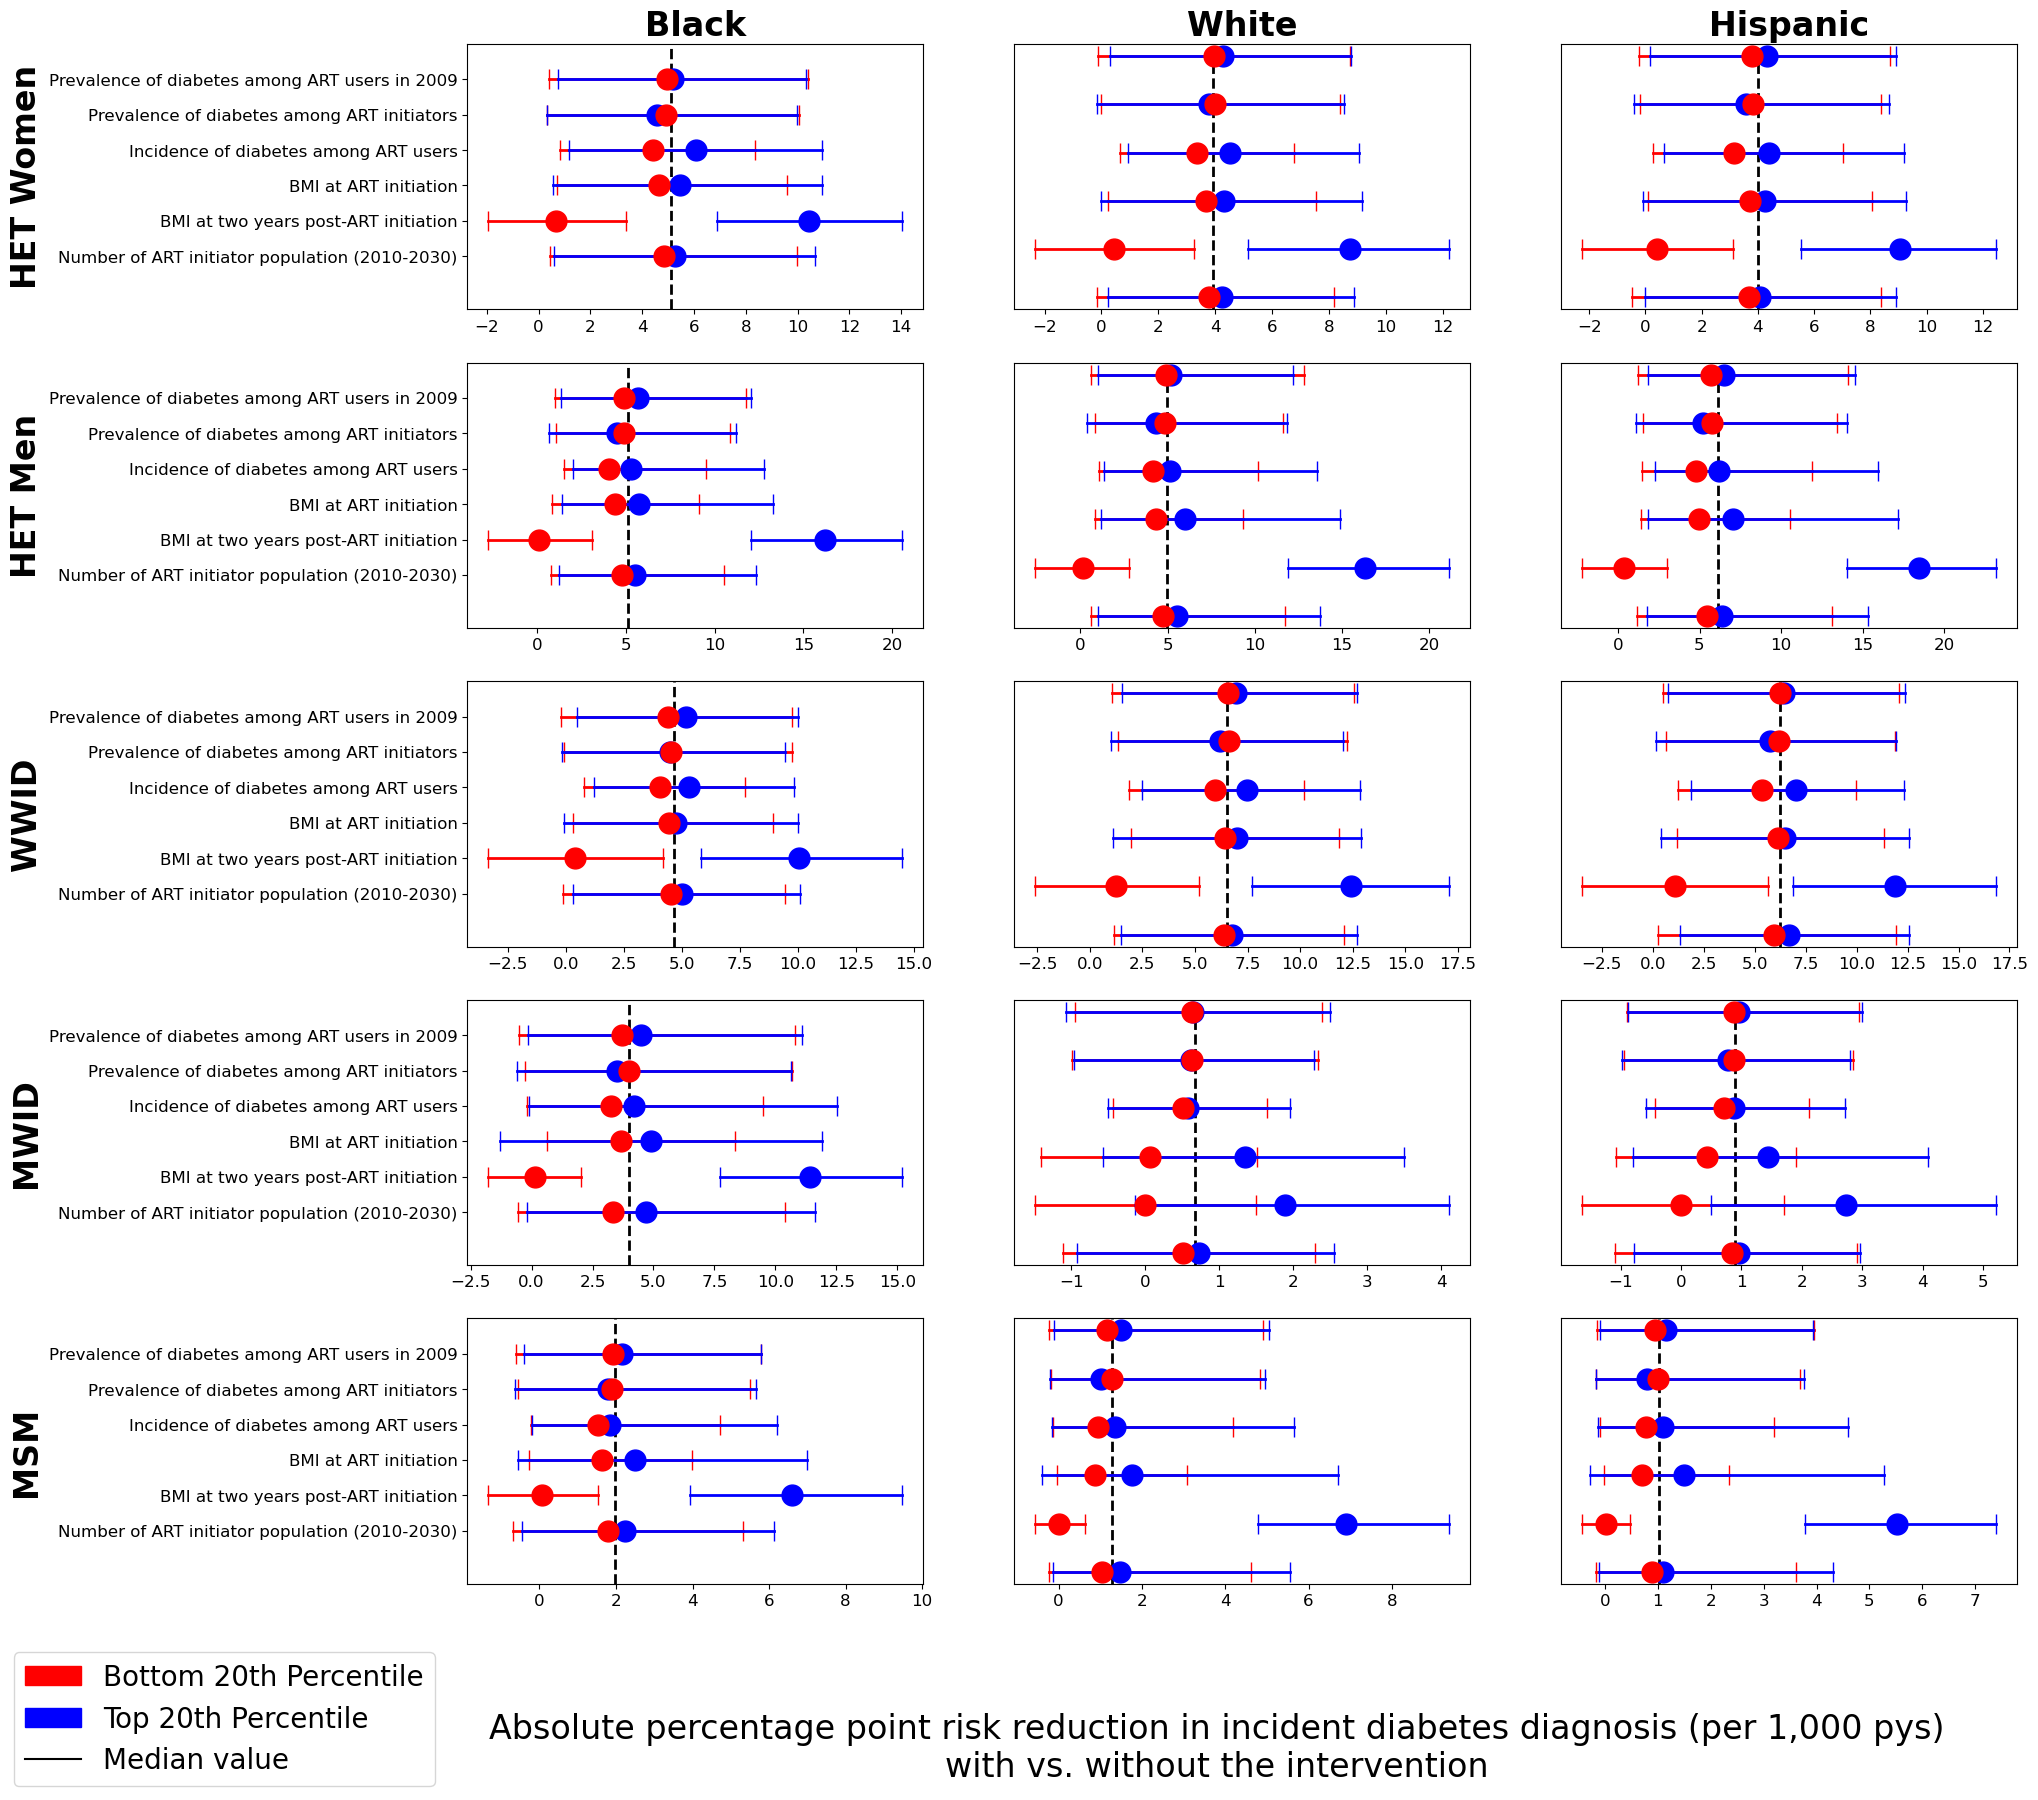

In [28]:
fig = multi_tornado_plot(difference_tornado_vals, baseline_risk_difference_df_sa, "Absolute percentage point risk reduction in incident diabetes diagnosis (per 1,000 pys)\nwith vs. without the intervention")
fig.savefig("../out/figs/absolute_group.png", bbox_inches="tight")
difference_tornado_vals.to_csv("../out/figs/absolute_group.csv")
baseline_risk_difference_df_sa.to_csv("../out/figs/absolute_baseline.csv")

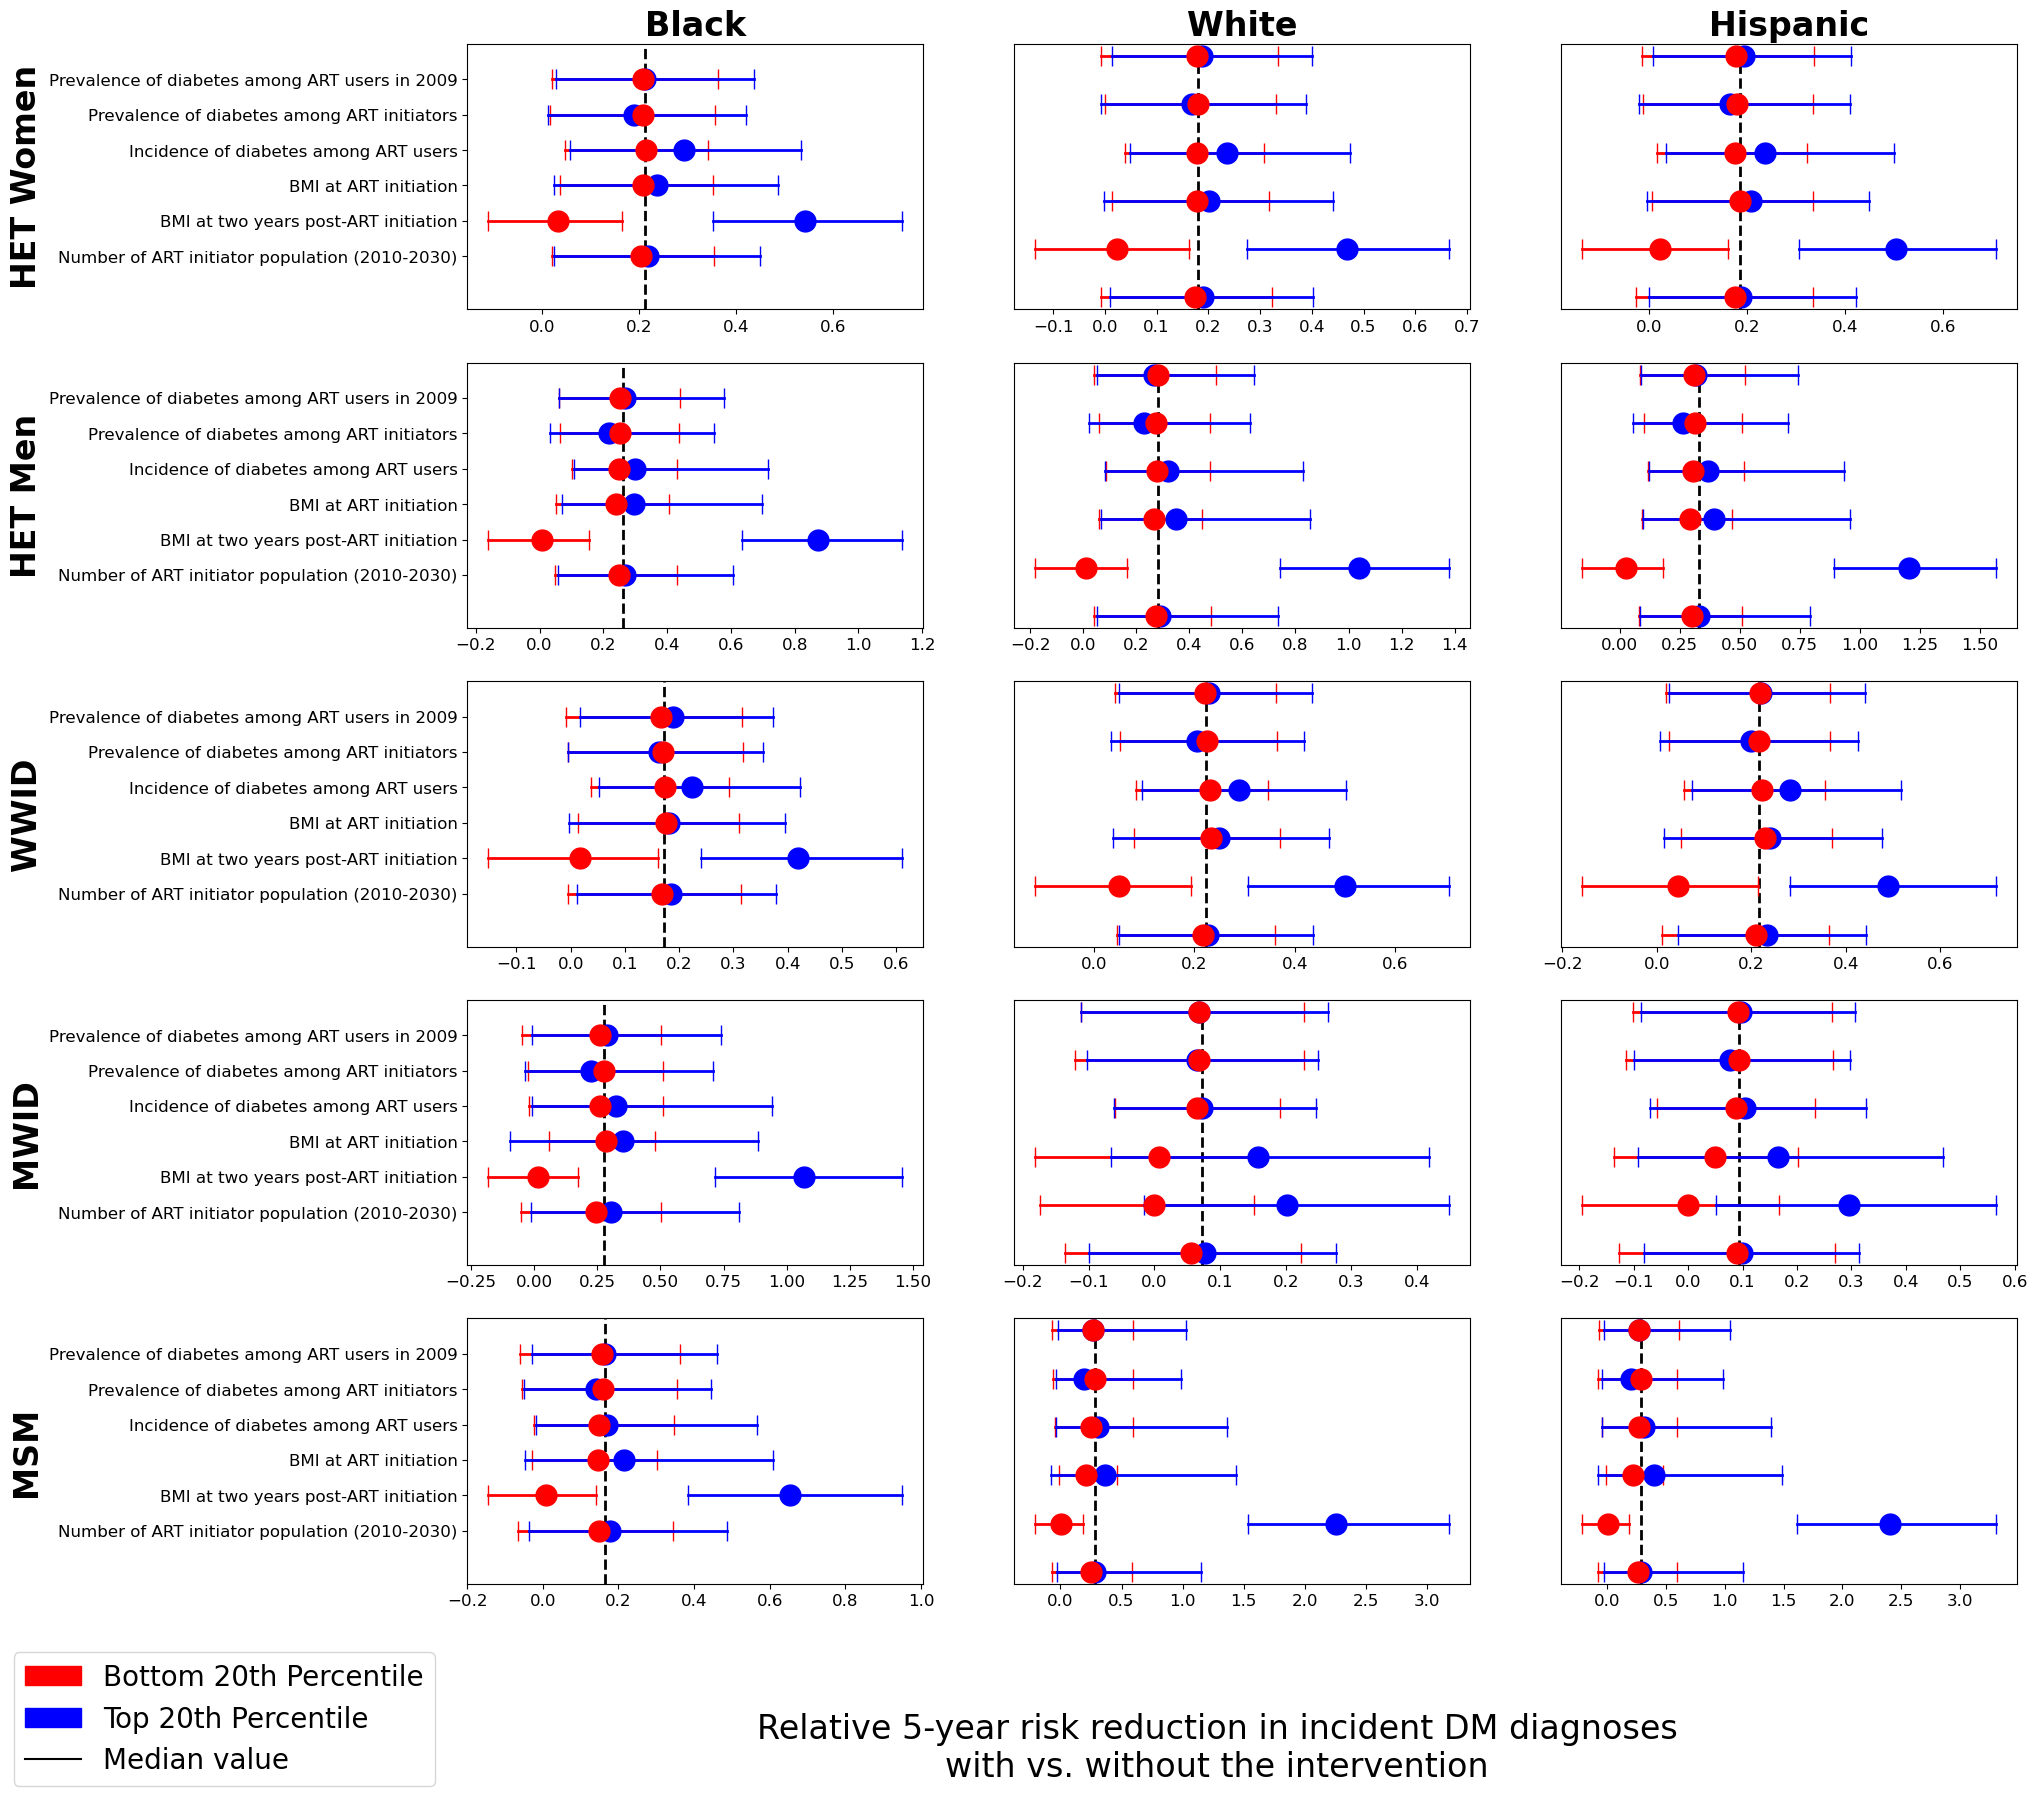

In [29]:
fig = multi_tornado_plot(relative_tornado_vals, baseline_risk_difference_df_sa_relative, "Relative 5-year risk reduction in incident DM diagnoses\nwith vs. without the intervention")
fig.savefig("../out/figs/relative_group.png", bbox_inches="tight")
relative_tornado_vals.to_csv("../out/figs/relative_group.csv")
baseline_risk_difference_df_sa_relative.to_csv("../out/figs/relative_baseline.csv")

# Overall

In [30]:
def overall_tornado_plot(tornado_vals, baseline_vals, x_axis_title, plot_loc, target_col="risk", flip=True):
    # create an axis
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    group = "overall"

    group_vals = tornado_vals[tornado_vals['group']==group].reset_index(drop=True)
    
    # plot parameters
    y_tick_label = group_vals['variable']
    ys = range(len(y_tick_label))[::-1]
    
    color_lesser = 'red'
    color_greater = 'blue'
    color_line = 'black'

    # Data to be visualized
    lesser_value = group_vals.iloc[:,2].values
    greater_value = group_vals.iloc[:,3].values
    base = baseline_vals[baseline_vals['group']==group][target_col].values[0]
    
    if flip:
        base *= -1
    # Add vertical line for median value
    ax.axvline(base, color=color_line, linewidth=2, label='Median value', linestyle='--')

    # Draw bars
    for y, value, value2 in zip(ys, lesser_value, greater_value):
        
        if flip:
            value = value.copy() * -1
            value2 = value2.copy() * -1
        
        # draw horizontal line markers for the uncertainty around lesser and greater
        ax.plot((value.iloc[0], value.iloc[2]), (y, y), linewidth=2, color=color_lesser, marker='|', markersize=15)
        ax.plot((value2.iloc[0], value2.iloc[2]), (y, y), linewidth=2, color=color_greater, marker='|', markersize=15)
        
        # draw markers for the median values
        ax.plot(value2.iloc[1], y , 'o', color=color_greater, markersize=15)
        ax.plot(value.iloc[1], y , 'o', color=color_lesser, markersize=15)
        
        
    # Add legend
    handles = [Patch(color=color_lesser, label='Bottom 20th percentile'), Patch(color=color_greater, label='Top 20th percentile'),
           Line2D([0], [0], color=color_line, linewidth=1.5, label='Median value')]
    ax.legend(handles=handles, loc=plot_loc, prop={'size': 16})

    
    # Modify the graph
    ax.set_ylim([-1.5, 6])
    ax.set_yticks(ys)
    ax.set_yticklabels(y_tick_label)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel(x_axis_title, fontsize=16)
        
    return fig
        

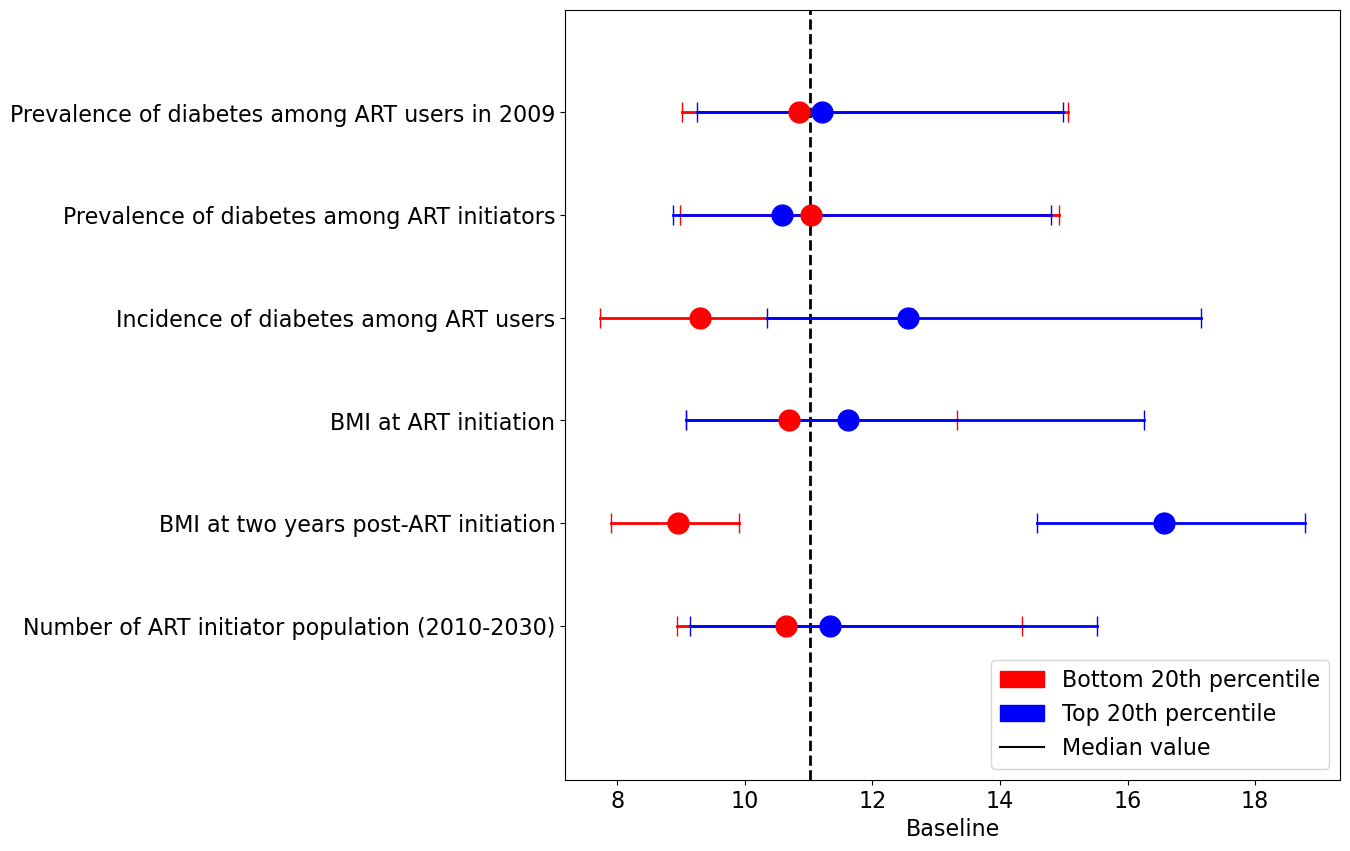

In [31]:
fig = overall_tornado_plot(baseline_tornado_vals, baseline_risk_sa_median, "Baseline", "lower right", flip=False)

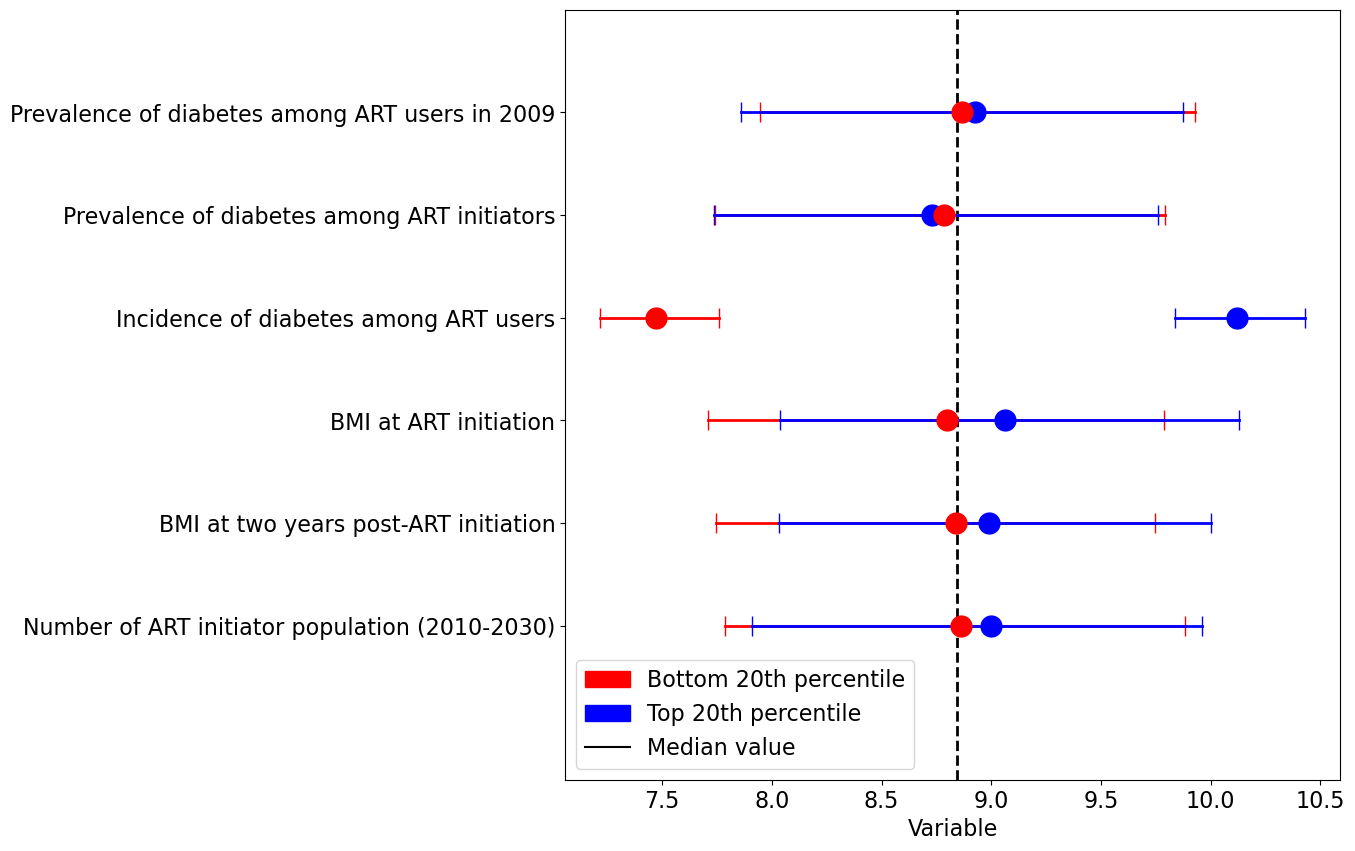

In [32]:
fig = overall_tornado_plot(variable_tornado_vals, variable_risk_sa_median, "Variable", "lower left", flip=False)

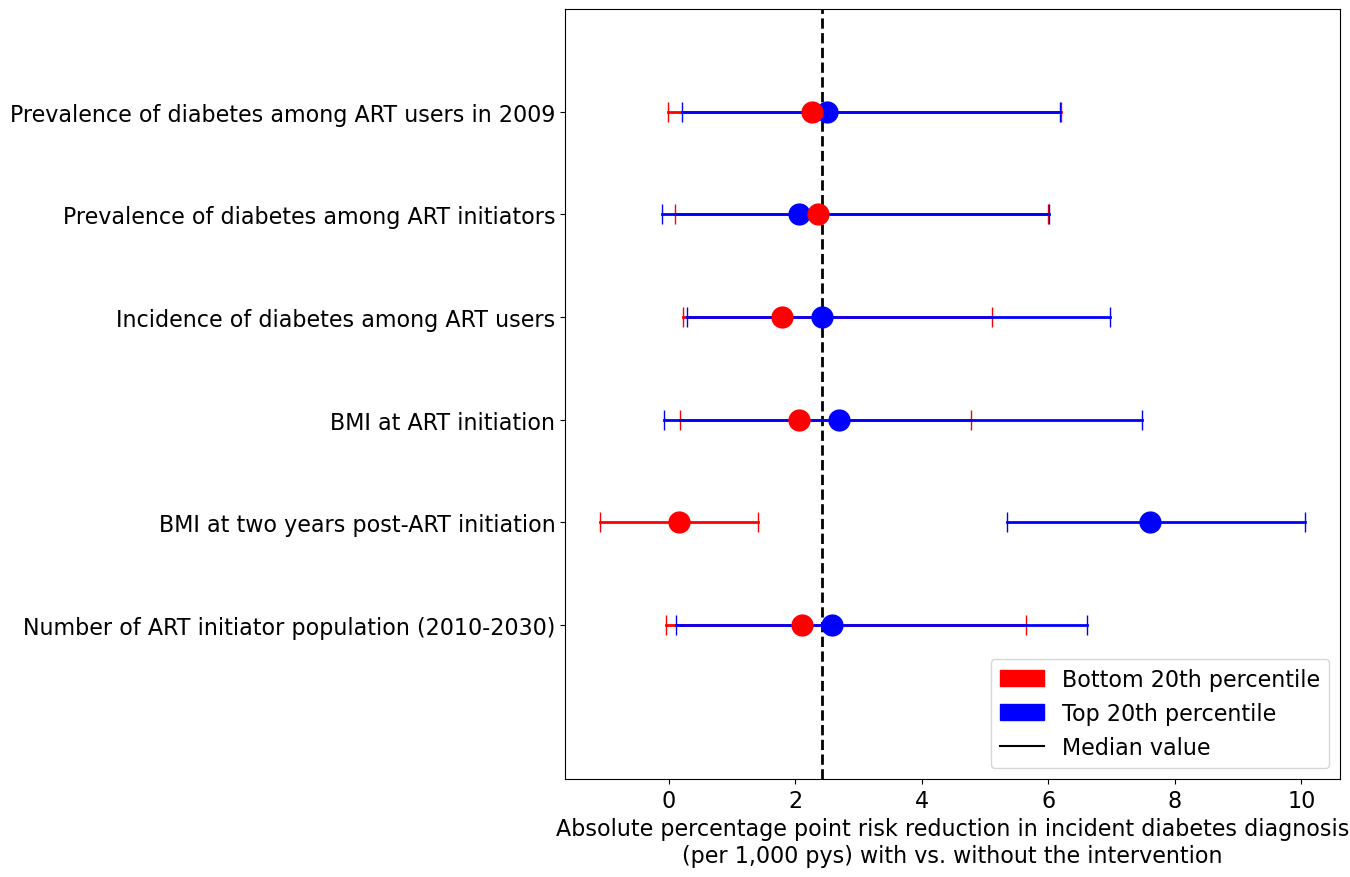

In [33]:
fig = overall_tornado_plot(difference_tornado_vals, baseline_risk_difference_df_sa, "Absolute percentage point risk reduction in incident diabetes diagnosis\n(per 1,000 pys) with vs. without the intervention", "lower right")
fig.savefig("../out/figs/absolute_overall.png", bbox_inches="tight")
difference_tornado_vals.to_csv("../out/figs/absolute_overall.csv")

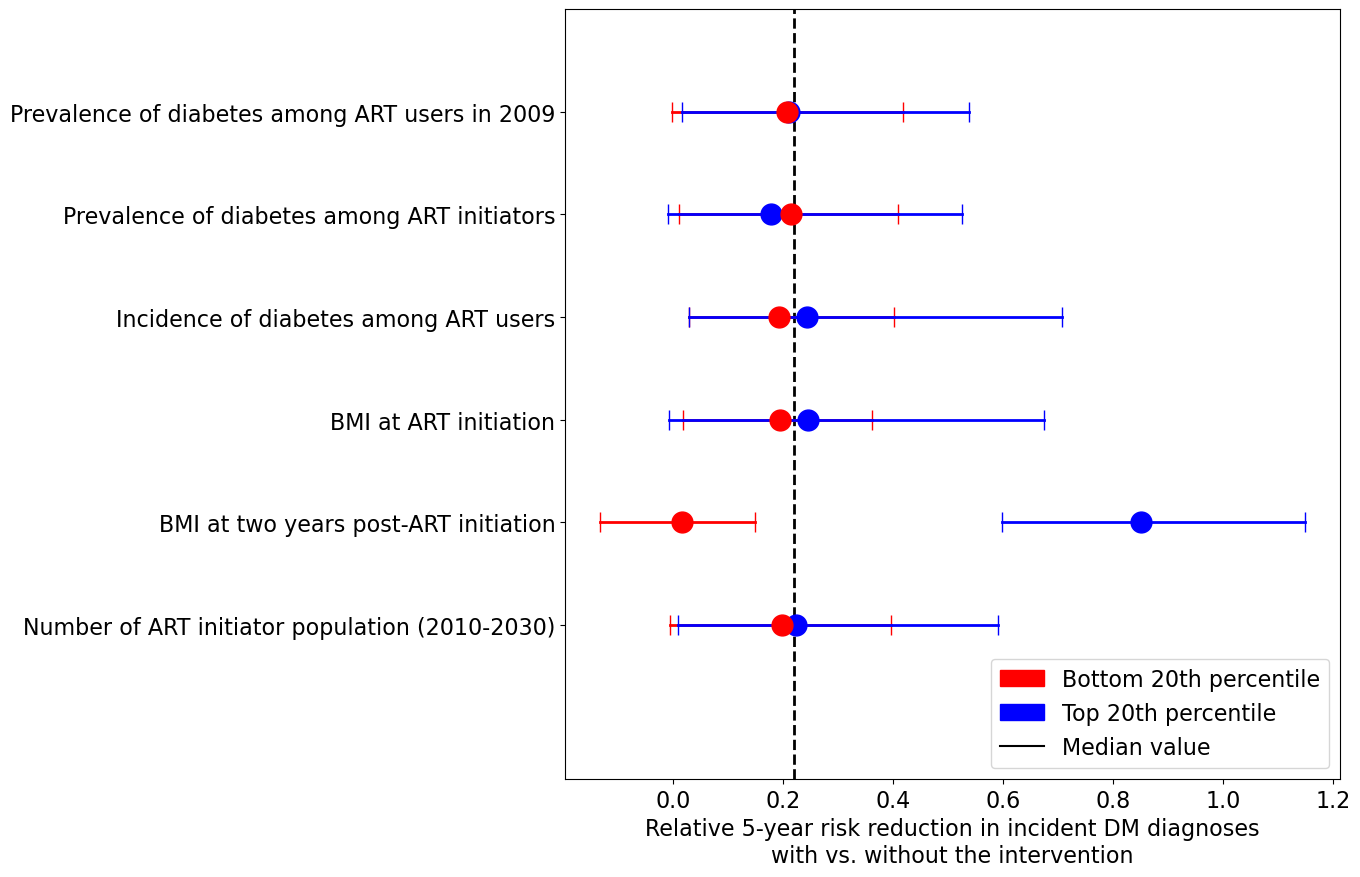

In [34]:
fig = overall_tornado_plot(relative_tornado_vals, baseline_risk_difference_df_sa_relative, "Relative 5-year risk reduction in incident DM diagnoses\nwith vs. without the intervention", "lower right")
fig.savefig("../out/figs/relative_overall.png", bbox_inches="tight")
relative_tornado_vals.to_csv("../out/figs/relative_overall.csv")

In [35]:
dm_baseline_tornado_vals = []
dm_variable_tornado_vals = []
dm_difference_tornado_vals = []
dm_relative_tornado_vals = []
for col in target_columns:
    baseline_vals, variable_vals, difference_vals, relative_difference_vals = calc_tornado_vals(
                                                                    bmi_int_eligible_risk_baseline_sa,
                                                                    bmi_int_eligible_risk_variable_sa,
                                                                    param_df_baseline_sa,
                                                                    param_df_variable_sa,
                                                                    col,
                                                                    target_col="dm_num",
                                                                    num_samples=num_samples,
                                                                    lesser=0.20,
                                                                    greater=0.80)
    
    dm_baseline_tornado_vals.append(baseline_vals)
    dm_variable_tornado_vals.append(variable_vals)
    dm_difference_tornado_vals.append(difference_vals)
    dm_relative_tornado_vals.append(relative_difference_vals)
    
dm_baseline_tornado_vals = pd.concat(dm_baseline_tornado_vals).reset_index(drop=True)    
dm_variable_tornado_vals = pd.concat(dm_variable_tornado_vals).reset_index(drop=True)
dm_difference_tornado_vals = pd.concat(dm_difference_tornado_vals).reset_index(drop=True)
dm_relative_tornado_vals = pd.concat(dm_relative_tornado_vals).reset_index(drop=True)

# rename variable to semantic labels
dm_baseline_tornado_vals['variable'] = dm_baseline_tornado_vals['variable'].map(variable_name_map)
dm_variable_tornado_vals['variable'] = dm_variable_tornado_vals['variable'].map(variable_name_map)
dm_difference_tornado_vals['variable'] = dm_difference_tornado_vals['variable'].map(variable_name_map)
dm_relative_tornado_vals['variable'] = dm_relative_tornado_vals['variable'].map(variable_name_map)

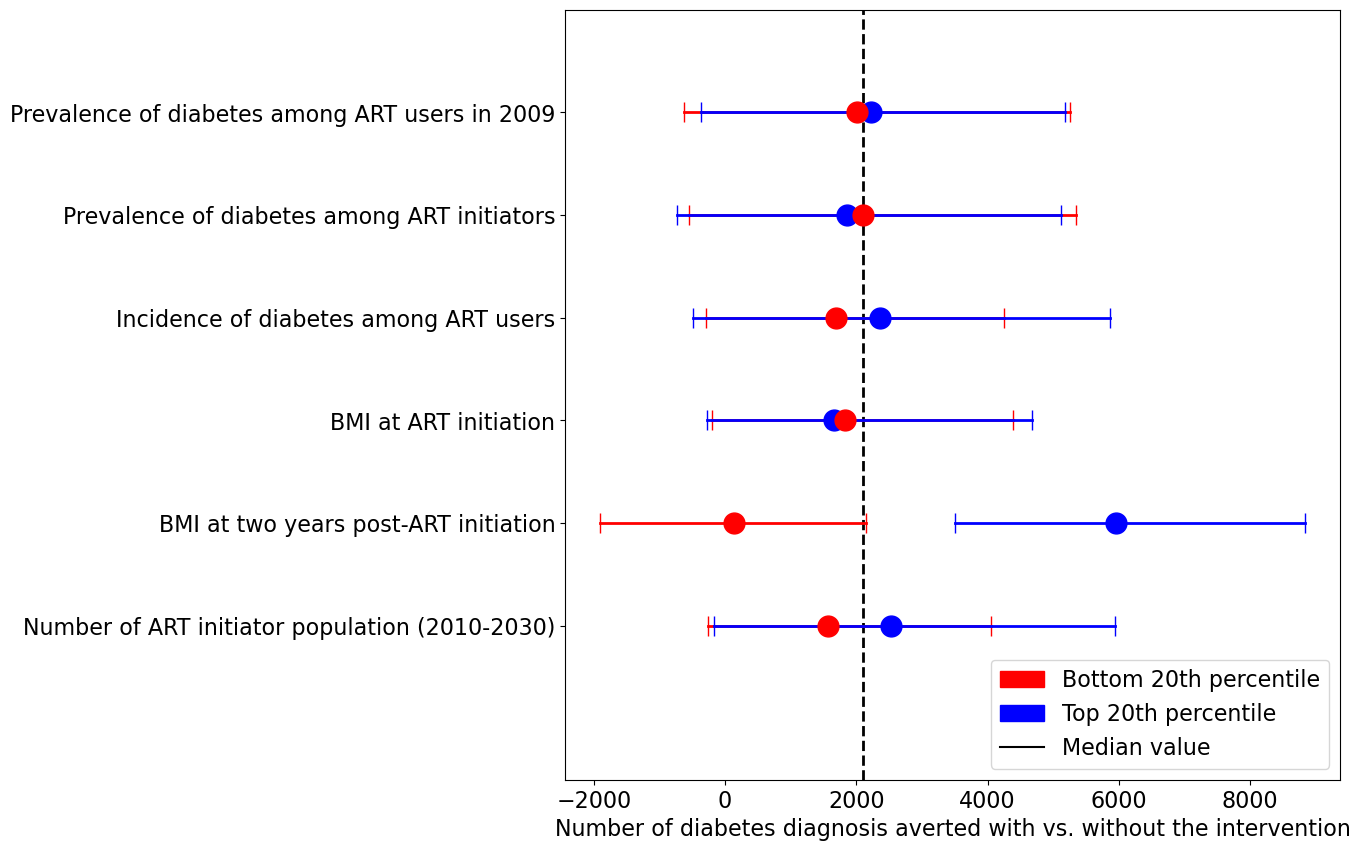

In [41]:
fig = overall_tornado_plot(dm_difference_tornado_vals, baseline_dm_difference_df_sa, "Number of diabetes diagnosis averted with vs. without the intervention", "lower right", target_col="dm_num")
fig.savefig("../out/dm_figs/absolute_overall_dm.png", bbox_inches="tight")
dm_difference_tornado_vals.to_csv("../out/dm_figs/absolute_overall_dm.csv")

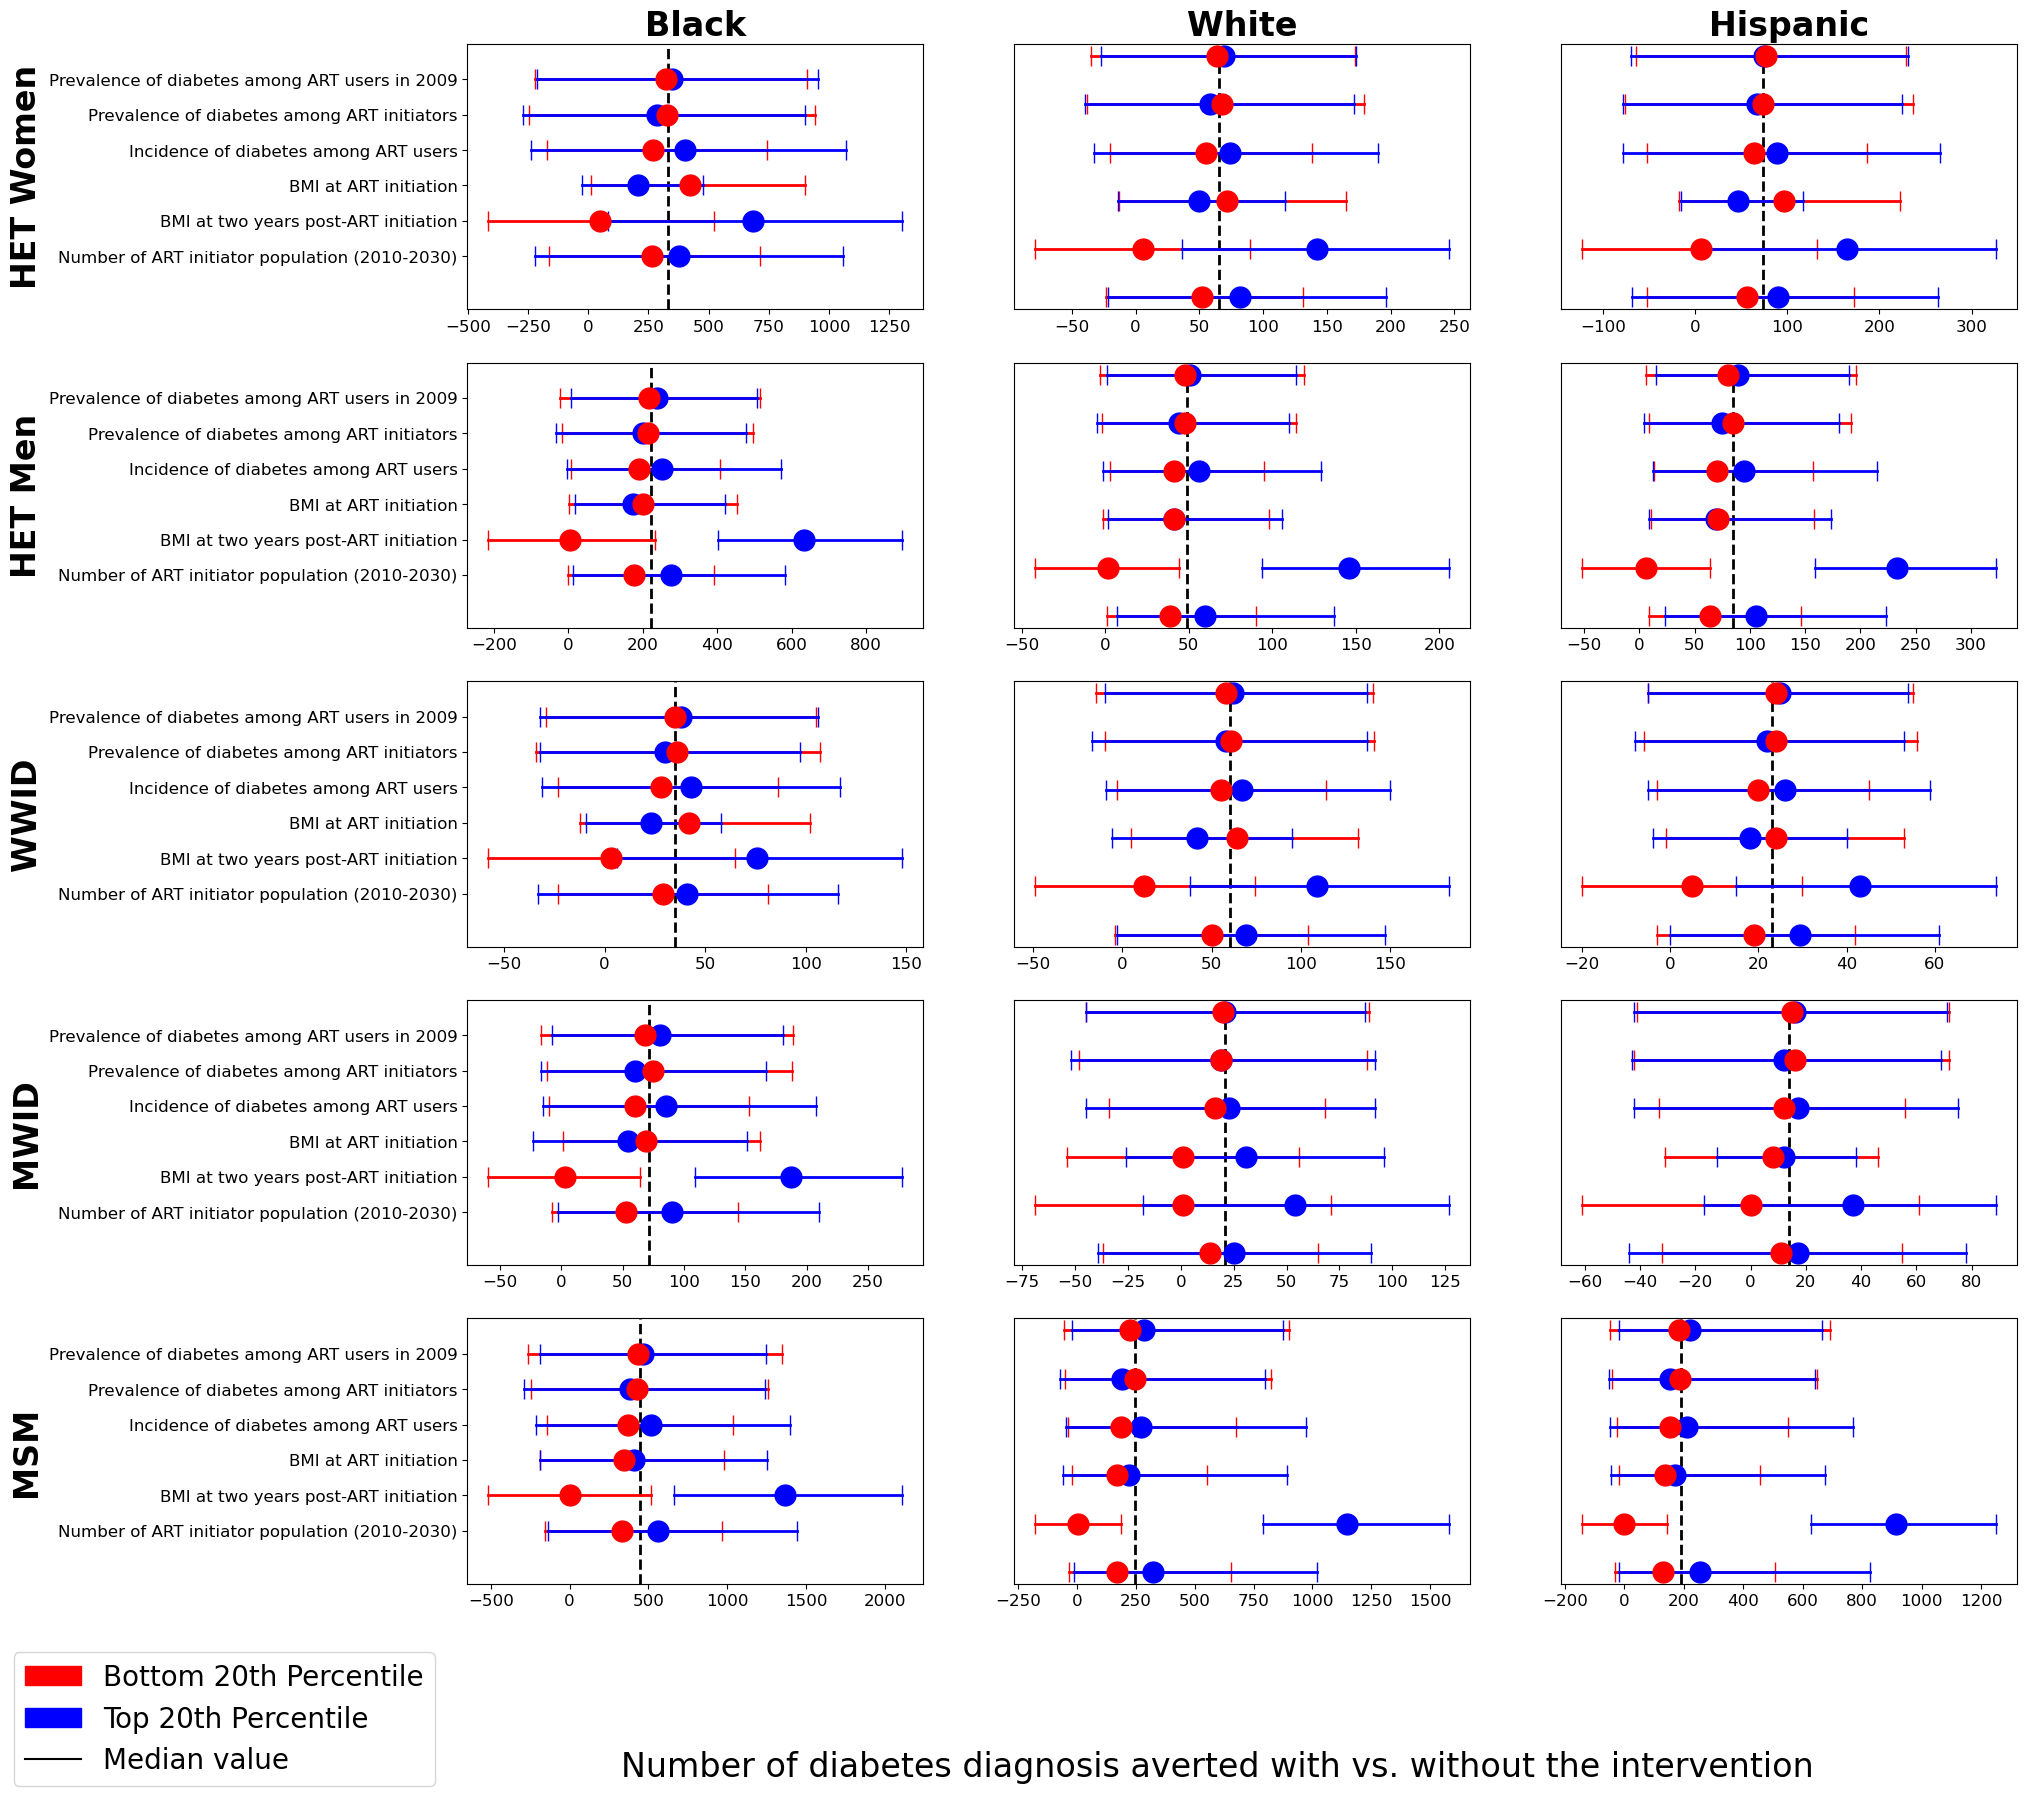

In [42]:
fig = multi_tornado_plot(dm_difference_tornado_vals, baseline_dm_difference_df_sa, "Number of diabetes diagnosis averted with vs. without the intervention", target_column="dm_num")
fig.savefig("../out/dm_figs/absolute_group_dm.png", bbox_inches="tight")
difference_tornado_vals.to_csv("../out/dm_figs/absolute_group_dm.csv")
baseline_risk_difference_df_sa.to_csv("../out/dm_figs/absolute_baseline_dm.csv")

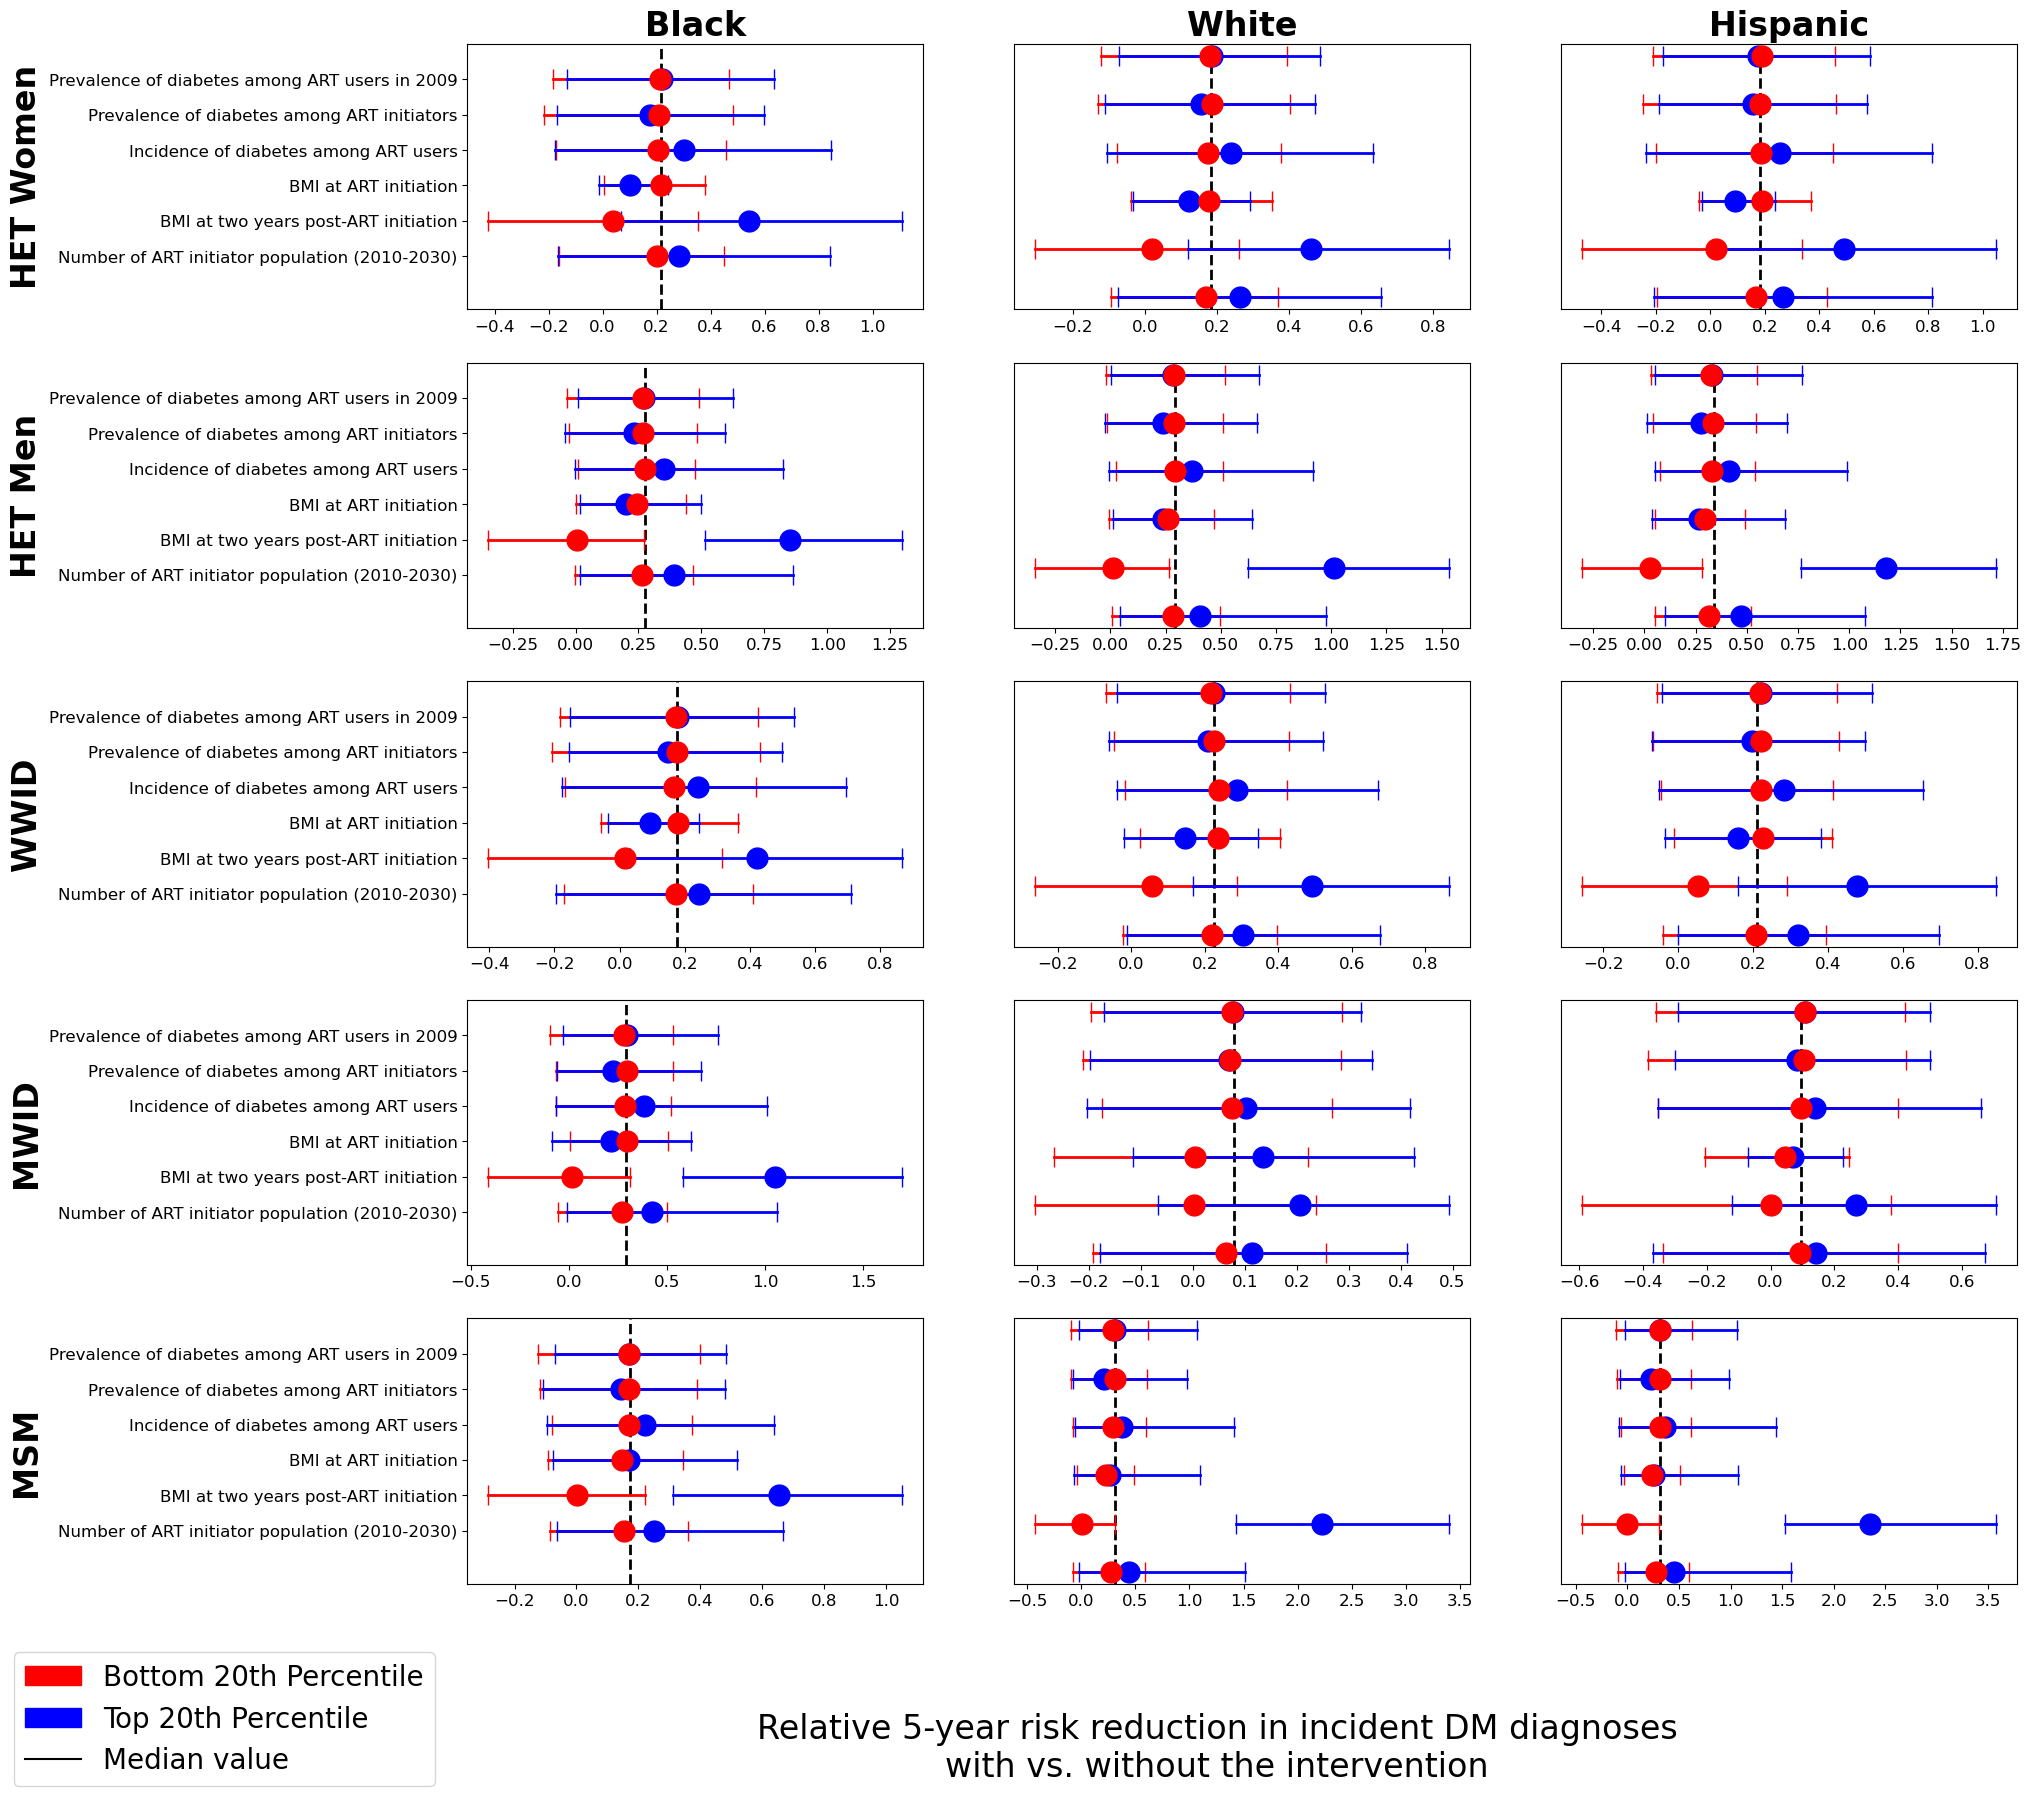

In [38]:
fig = multi_tornado_plot(dm_relative_tornado_vals, baseline_dm_difference_df_sa_relative, "Relative 5-year risk reduction in incident DM diagnoses\nwith vs. without the intervention", target_column="dm_num")
fig.savefig("../out/figs/relative_group_dm.png", bbox_inches="tight")
relative_tornado_vals.to_csv("../out/figs/relative_group_dm.csv")
baseline_dm_difference_df_sa_relative.to_csv("../out/figs/relative_baseline_dm.csv")

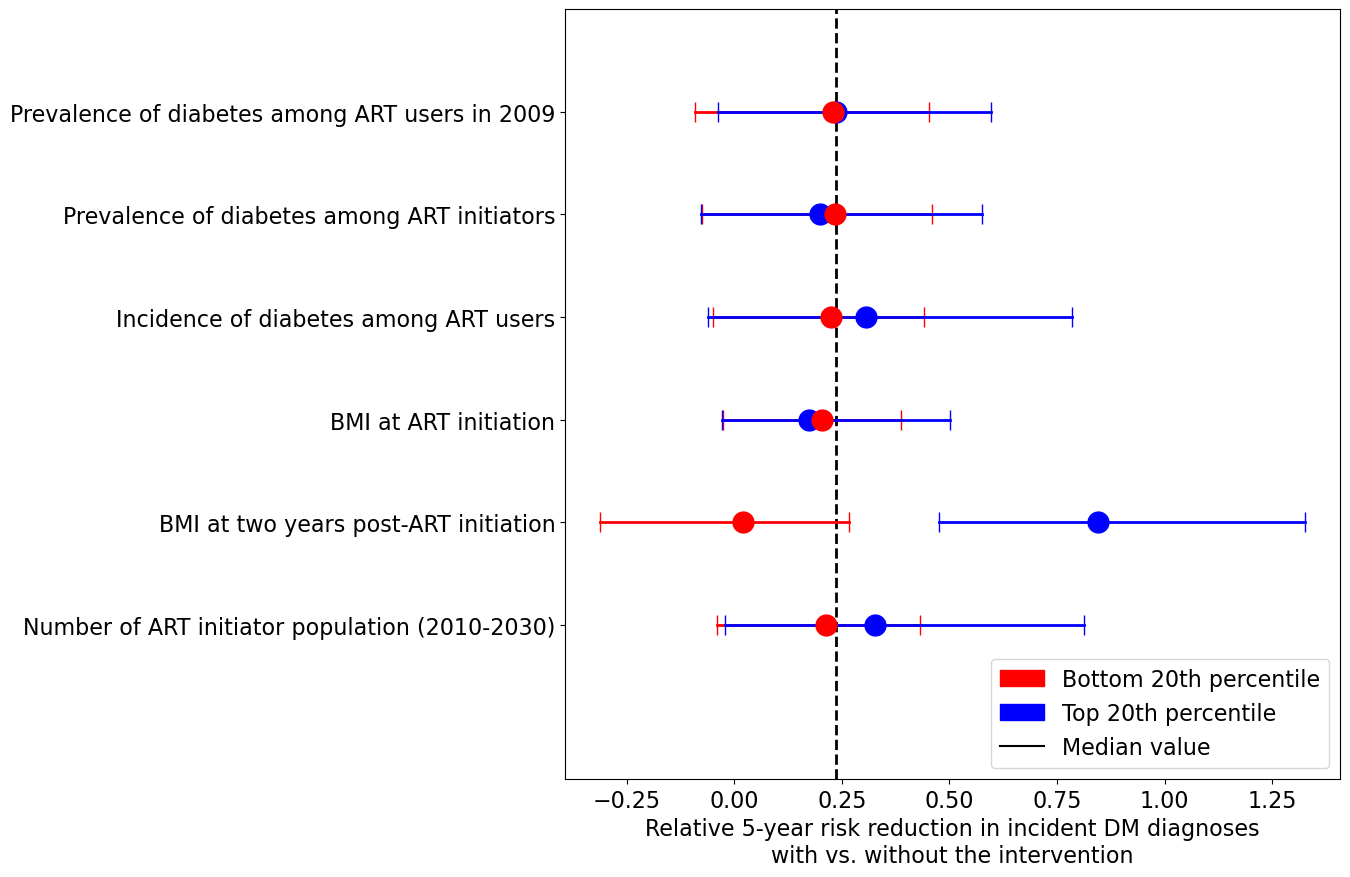

In [40]:
fig = overall_tornado_plot(dm_relative_tornado_vals, baseline_dm_difference_df_sa_relative, "Relative 5-year risk reduction in incident DM diagnoses\nwith vs. without the intervention", "lower right", target_col="dm_num")
fig.savefig("../out/figs/relative_overall_dm.png", bbox_inches="tight")
relative_tornado_vals.to_csv("../out/figs/relative_overall_dm.csv")